# Introduction 

Ce projet concerne le Travail de Bachelor sur l'analyse de données en temps réel sur l'arbitrage du light-contact boxing. Le but est de signaler en temps réel les divergences de points attribués par les juges.


## Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.dates as mdates
import scipy.stats as stats
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

## Data exploration
Chargement du fichier CSV LCBA_scores.csv


In [3]:
data = pd.read_csv('LCBA_scores.csv')

cols_to_display = ['score_id', 'red_point','red_penalty', 'blue_point','blue_penalty', 'date_create_app', 'judge_id', 'match_id']
data[cols_to_display]

,score_id,red_point,red_penalty,blue_point,blue_penalty,date_create_app,judge_id,match_id
0,1,0,0,0,0,NaN,114816,21089
1,2,0,0,0,0,NaN,114822,21089
2,3,0,0,0,0,NaN,114824,21089
3,4,0,0,0,0,NaN,114826,21093
4,5,0,0,0,0,NaN,114813,21093
...,...,...,...,...,...,...,...,...
38778,38952,1,0,0,0,2023-04-15 14:18:52.2+00,115226,22514
38779,38953,1,0,0,0,2023-04-15 14:18:51.485+00,114927,22514
38780,38954,1,0,0,0,2023-04-15 14:18:56.33+00,114927,22514
38781,38955,1,0,0,0,2023-04-15 14:18:56.889+00,114926,22514


In [4]:
num_distinct_match_ids = data['match_id'].nunique()
print("Nombre de match_id distincts :", num_distinct_match_ids)

Nombre de match_id distincts : 813


Colonne red_point

In [5]:
data.red_point.describe()

count    38783.000000
mean         0.456102
std          0.561632
min         -3.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: red_point, dtype: float64

Colonne blue_point

In [6]:
data.blue_point.describe()

count    38783.000000
mean         0.457288
std          0.556790
min         -3.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: blue_point, dtype: float64

Colonne date_create_app

In [7]:
data.date_create_app.describe()

count                          36786
unique                         36782
top       2022-06-18 12:36:59.029+00
freq                               2
Name: date_create_app, dtype: object

On voit qu'il existe des valeurs null et négatives, quelques modifications/correction sonz apporter.
Nous allons prémièrement se concentrer sur un seul match_id.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38783 entries, 0 to 38782
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   score_id                  38783 non-null  int64  
 1   red_penalty               38783 non-null  int64  
 2   red_point                 38783 non-null  int64  
 3   blue_penalty              38783 non-null  int64  
 4   blue_point                38783 non-null  int64  
 5   date_create               38783 non-null  object 
 6   date_change               38783 non-null  object 
 7   judge_id                  38783 non-null  int64  
 8   match_id                  38783 non-null  int64  
 9   date_create_app           36786 non-null  object 
 10  uuid                      36786 non-null  object 
 11  judge_club_id             38783 non-null  int64  
 12  match_id.1                38783 non-null  int64  
 13  PalmaresDate              38783 non-null  object 
 14  winner

In [9]:
# Grouper les données par match_id et judge_id, puis compter le nombre de lignes pour chaque groupe
result = data.groupby(['match_id', 'judge_id']).size().reset_index(name='count')

# Afficher le résultat
print(result)


      match_id  judge_id  count
0        21089    114816     24
1        21089    114822     17
2        21089    114824     22
3        21092    113583      9
4        21092    114823     14
...        ...       ...    ...
2108     22514    114927     28
2109     22514    115226     18
2110     22515    114926      4
2111     22515    114927      8
2112     22515    115226     41

[2113 rows x 3 columns]


## Data preparation

### Conversion date
On constate qu'il considère les format de date comme des objets. On les convertit pour pour faciliter les prochains calculs sur la série temporelle. Le datetime64[ns] est un type de données utilisé dans Pandas pour représenter les dates et heures avec une précision jusqu'à la nanoseconde. 

In [10]:
cols_to_convert = ['date_create', 'date_change','date_create_app','PalmaresDate','PalmaresRealEndTime','PalmaresRealStartTime','open_time']
data[cols_to_convert] = data[cols_to_convert].apply(pd.to_datetime)

### Suppresion des colonnes null

In [11]:
null_rows = data[data['date_create_app'].isnull()]

cols_to_display2 = ['score_id', 'red_point', 'blue_point', 'judge_id', 'date_create_app']
print(null_rows[cols_to_display2])

# Supprimer les lignes
data = data.dropna(subset=['date_create_app'])

       score_id  red_point  blue_point  judge_id date_create_app
0             1          0           0    114816             NaT
1             2          0           0    114822             NaT
2             3          0           0    114824             NaT
3             4          0           0    114826             NaT
4             5          0           0    114813             NaT
...         ...        ...         ...       ...             ...
38639     38813          0           0    114927             NaT
38640     38814          0           0    114926             NaT
38711     38885          0           0    114927             NaT
38712     38886          0           0    114926             NaT
38713     38887          0           0    115226             NaT

[1997 rows x 5 columns]


## Modelling
### Graphes

In [12]:
total_points = data.groupby("match_id")[["red_point", "blue_point"]].sum().reset_index()

print(total_points)

     match_id  red_point  blue_point
0       21089         30          26
1       21092         12          25
2       21093         21          32
3       21095         31          37
4       21096         33          34
..        ...        ...         ...
803     22511         11          26
804     22512         10          10
805     22513         41          25
806     22514         34          35
807     22515         25          25

[808 rows x 3 columns]


In [13]:
score_diffs = []

# Parcours des match_ids
for match_id in data['match_id'].unique():
    match_data = data[data['match_id'] == match_id]
    
    # Calcul du nombre total de points attribués par chaque judge_id
    red_scores = match_data.groupby('judge_id')['red_point'].sum()
    blue_scores = match_data.groupby('judge_id')['blue_point'].sum()
    
    score_diff = max(red_scores.max(),blue_scores.max()) - min(red_scores.min(),blue_scores.min())
    score_diffs.append(score_diff)

# Calcul de la moyenne des écarts
mean_score_diff = sum(score_diffs) / len(score_diffs)

# Affichage du résultat
print("Moyenne des écarts:", mean_score_diff)


Moyenne des écarts: 7.196782178217822


In [14]:
cols_to_display = ['score_id', 'red_point','red_penalty', 'blue_point','blue_penalty', 'date_create_app', 'judge_id', 'match_id']
data[cols_to_display]

,score_id,red_point,red_penalty,blue_point,blue_penalty,date_create_app,judge_id,match_id
5,6,0,0,1,0,2021-06-26 11:14:51.610000+00:00,114816,21089
6,7,0,0,1,0,2021-06-26 11:14:48.802000+00:00,114822,21089
7,8,1,0,0,0,2021-06-26 11:14:53.035000+00:00,114816,21089
8,9,0,0,1,0,2021-06-26 11:14:53.541000+00:00,114816,21089
9,10,0,0,1,0,2021-06-26 11:14:52.862000+00:00,114826,21093
...,...,...,...,...,...,...,...,...
38778,38952,1,0,0,0,2023-04-15 14:18:52.200000+00:00,115226,22514
38779,38953,1,0,0,0,2023-04-15 14:18:51.485000+00:00,114927,22514
38780,38954,1,0,0,0,2023-04-15 14:18:56.330000+00:00,114927,22514
38781,38955,1,0,0,0,2023-04-15 14:18:56.889000+00:00,114926,22514


In [15]:
scores_by_judge = data.groupby(['match_id', 'judge_id']).sum()[['red_point', 'blue_point', 'red_penalty', 'blue_penalty']]
print(scores_by_judge)

                   red_point  blue_point  red_penalty  blue_penalty
match_id judge_id                                                  
21089    114816           12           7            4             3
         114822            8           8            4             3
         114824           10          11            4             3
21092    113583            2           6            1             1
         114823            4           9            1             1
...                      ...         ...          ...           ...
22514    114927           12          15            3             4
         115226           10           7            3             4
22515    114926            2           1            0             0
         114927            5           2            0             0
         115226           18          22            0             0

[2099 rows x 4 columns]


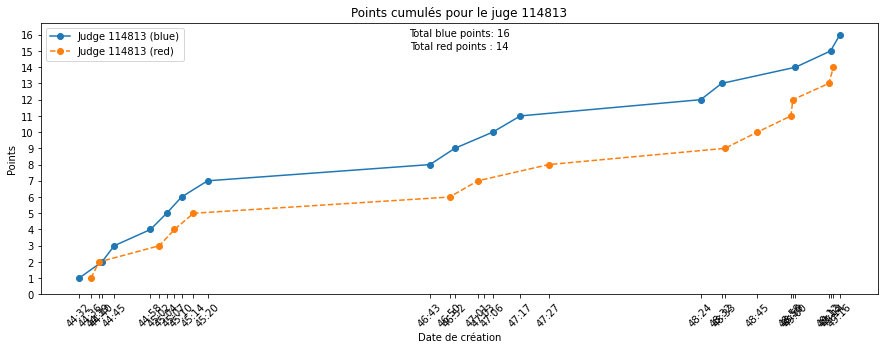

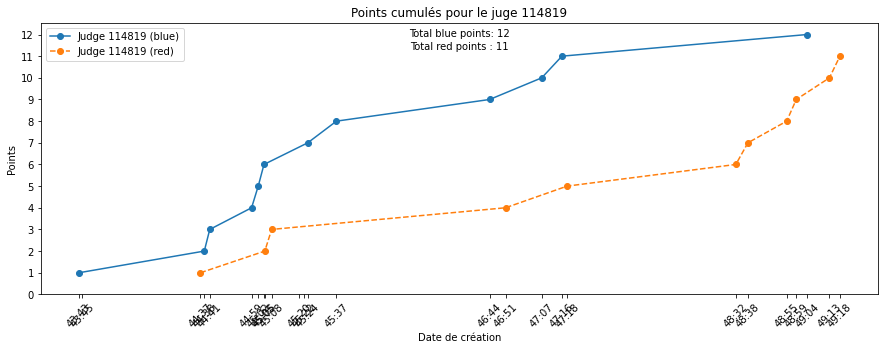

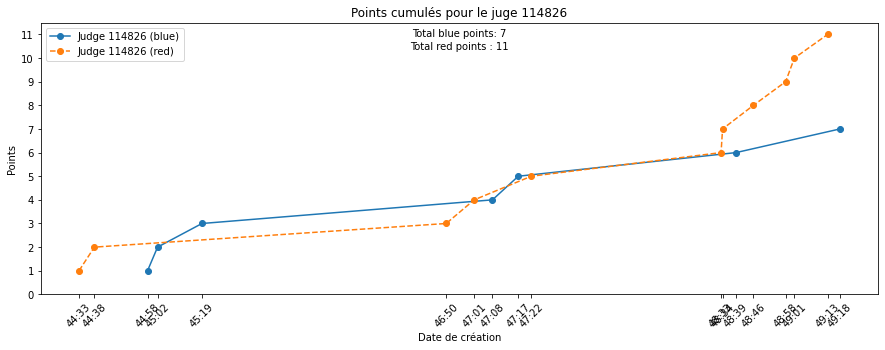

In [16]:
data = data[data['match_id'] == 21096]
data = data.sort_values('date_create_app')

data_blue_points = data[data['blue_point'] == 1][['date_create_app', 'blue_point']]
data_red_points = data[data['red_point'] == 1][['date_create_app', 'red_point']]

grouped_data = data.groupby(['judge_id'])

# Boucle sur les groupes pour créer un graphe par judge_id
for name, group in grouped_data:
    group_blue_points = group[group['date_create_app'].isin(data_blue_points['date_create_app'])]
    group_red_points = group[group['date_create_app'].isin(data_red_points['date_create_app'])]

    cumulative_blue_points = group_blue_points['blue_point'].cumsum()
    cumulative_red_points = group_red_points['red_point'].cumsum()

    # Création d'un graphe pour chaque judge_id
    fig, axs = plt.subplots(figsize=(15, 5))
    
    axs.plot(group_blue_points['date_create_app'], cumulative_blue_points,marker='o', label=f"Judge {name} (blue)")
    axs.plot(group_red_points['date_create_app'], cumulative_red_points, marker='o',label=f"Judge {name} (red)", linestyle='--')

    # Configuration du graphe
    axs.set_xlabel("Date de création")
    axs.set_ylabel("Points")
    axs.legend()

    plt.xticks(rotation=45)
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

    axs.set_xticks(group['date_create_app'])
    axs.set_xticklabels(group['date_create_app'].dt.strftime('%M:%S'))

    max_points = max(cumulative_blue_points.max(), cumulative_red_points.max()) + 1
    axs.set_yticks(range(0, max_points))

    total_blue_points = group_blue_points['blue_point'].sum()
    axs.text(0.5, 0.95, f"Total blue points: {total_blue_points}", transform=axs.transAxes, ha="center")

    total_red_points = group_red_points['red_point'].sum()
    axs.text(0.5, 0.9, f"Total red points : {total_red_points}", transform=axs.transAxes, ha="center")

    plt.title(f"Points cumulés pour le juge {name}")
    plt.show()

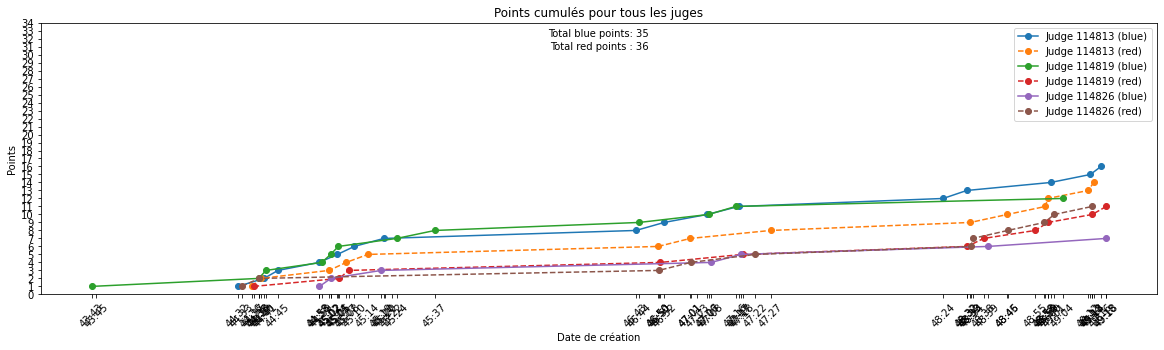

In [17]:

data = data[data['match_id'] == 21096]
data = data.sort_values('date_create_app')

data_blue_points = data[data['blue_point'] == 1][['date_create_app', 'blue_point']]
data_red_points = data[data['red_point'] == 1][['date_create_app', 'red_point']]

grouped_data = data.groupby(['judge_id'])

# Création du graphe
fig, ax = plt.subplots(figsize=(20, 5))

# Boucle sur les groupes pour ajouter les points cumulés pour chaque juge
for name, group in grouped_data:
    group_blue_points = group[group['date_create_app'].isin(data_blue_points['date_create_app'])]
    group_red_points = group[group['date_create_app'].isin(data_red_points['date_create_app'])]

    cumulative_blue_points = group_blue_points['blue_point'].cumsum()
    cumulative_red_points = group_red_points['red_point'].cumsum()

    ax.plot(group_blue_points['date_create_app'], cumulative_blue_points, marker='o', label=f"Judge {name} (blue)")
    ax.plot(group_red_points['date_create_app'], cumulative_red_points, marker='o', label=f"Judge {name} (red)", linestyle='--')

# Configuration du graphe
ax.set_xlabel("Date de création")
ax.set_ylabel("Points")
ax.legend()

plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

ax.set_xticks(data['date_create_app'])
ax.set_xticklabels(data['date_create_app'].dt.strftime('%M:%S'))

max_points = max(data['blue_point'].cumsum().max(), data['red_point'].cumsum().max()) + 1
ax.set_yticks(range(0, max_points))

total_blue_points = data_blue_points['blue_point'].sum()
ax.text(0.5, 0.95, f"Total blue points: {total_blue_points}", transform=ax.transAxes, ha="center")

total_red_points = data_red_points['red_point'].sum()
ax.text(0.5, 0.9, f"Total red points : {total_red_points}", transform=ax.transAxes, ha="center")

plt.title(f"Points cumulés pour tous les juges")
plt.show()

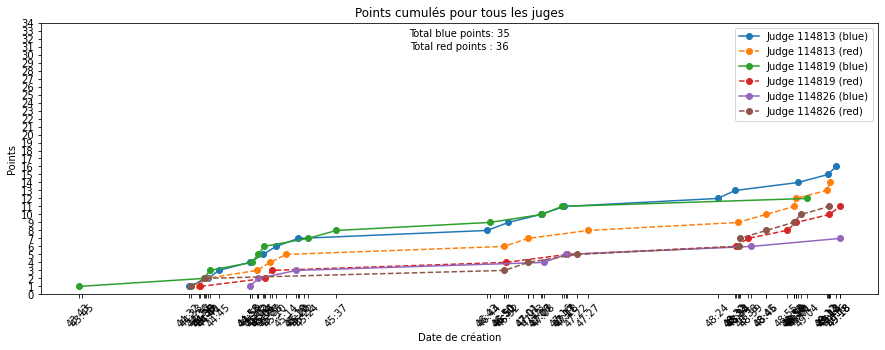

In [18]:
data = data[data['match_id'] == 21096]
data = data.sort_values('date_create_app')

data_blue_points = data[data['blue_point'] == 1][['date_create_app', 'blue_point']]
data_red_points = data[data['red_point'] == 1][['date_create_app', 'red_point']]

grouped_data = data.groupby(['judge_id'])

# Création du graphe
fig, ax = plt.subplots(figsize=(15, 5))

# Boucle sur les groupes pour ajouter les points cumulés pour chaque juge
for name, group in grouped_data:
    group_blue_points = group[group['date_create_app'].isin(data_blue_points['date_create_app'])]
    group_red_points = group[group['date_create_app'].isin(data_red_points['date_create_app'])]

    cumulative_blue_points = group_blue_points['blue_point'].cumsum()
    cumulative_red_points = group_red_points['red_point'].cumsum()

    ax.plot(group_blue_points['date_create_app'], cumulative_blue_points, marker='o', label=f"Judge {name} (blue)")
    ax.plot(group_red_points['date_create_app'], cumulative_red_points, marker='o', label=f"Judge {name} (red)", linestyle='--')

# Configuration du graphe
ax.set_xlabel("Date de création")
ax.set_ylabel("Points")
ax.legend()

plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

ax.set_xticks(data['date_create_app'])
ax.set_xticklabels(data['date_create_app'].dt.strftime('%M:%S'))

max_points = max(data['blue_point'].cumsum().max(), data['red_point'].cumsum().max()) + 1
ax.set_yticks(range(0, max_points))

total_blue_points = data_blue_points['blue_point'].sum()
ax.text(0.5, 0.95, f"Total blue points: {total_blue_points}", transform=ax.transAxes, ha="center")

total_red_points = data_red_points['red_point'].sum()
ax.text(0.5, 0.9, f"Total red points : {total_red_points}", transform=ax.transAxes, ha="center")

plt.title(f"Points cumulés pour tous les juges")
plt.show()

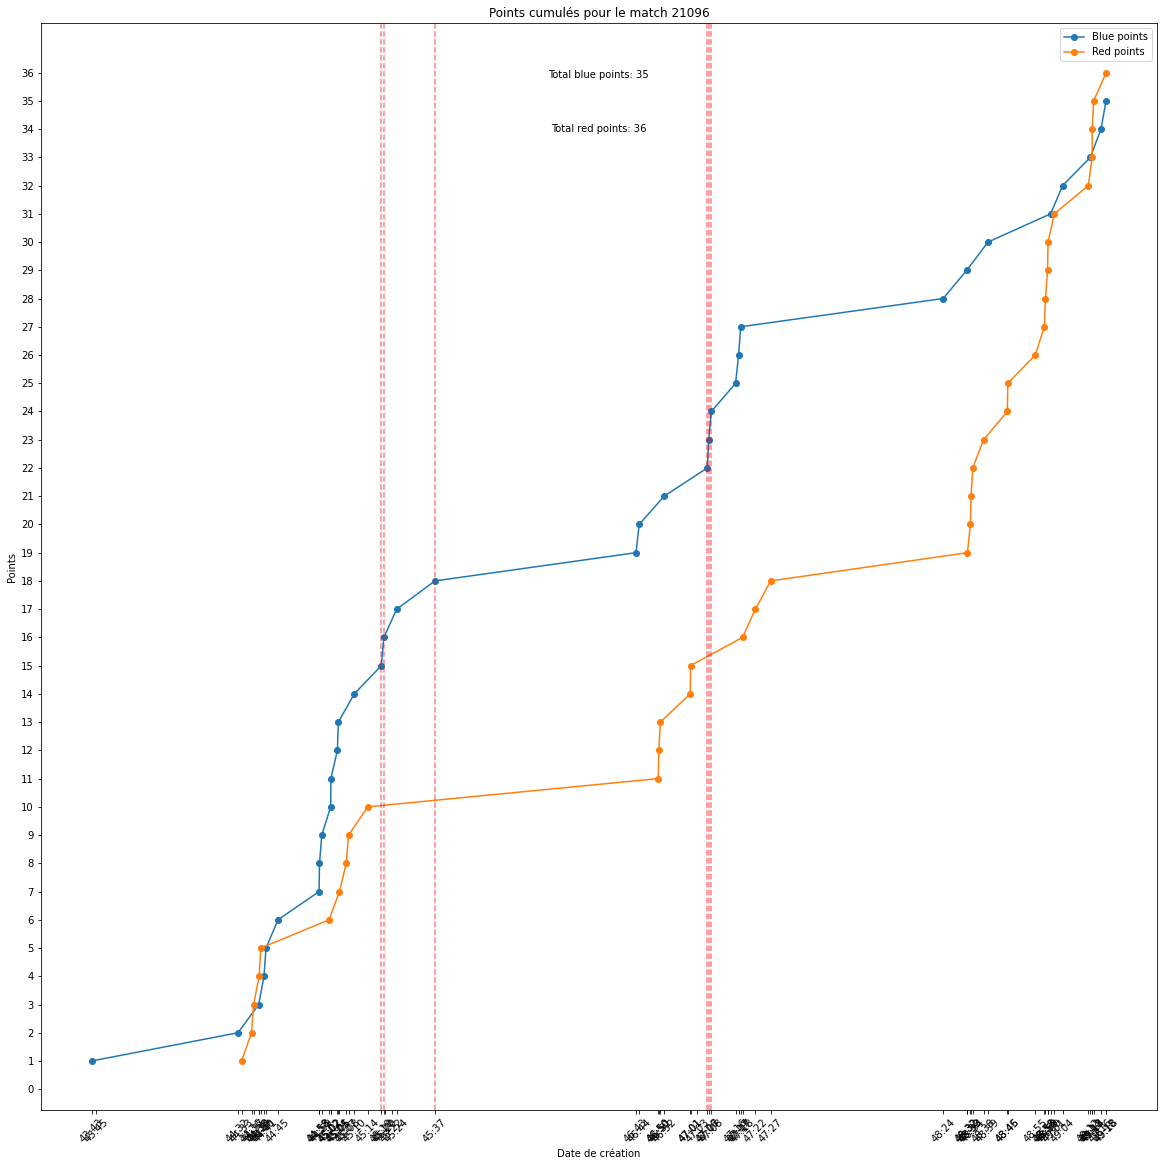

In [19]:
data = data[data['match_id'] == 21096]

data = data.sort_values('date_create_app')

data_red_points = data[data['red_point'] == 1][['date_create_app', 'red_point']]
data_blue_points = data[data['blue_point'] == 1][['date_create_app', 'blue_point']]


cumulative_red_points = data_red_points['red_point'].cumsum()
cumulative_blue_points = data_blue_points['blue_point'].cumsum()

fig, ax = plt.subplots(figsize=(20, 20))

ax.plot(data_blue_points['date_create_app'], cumulative_blue_points, marker='o', label='Blue points')
ax.plot(data_red_points['date_create_app'], cumulative_red_points, marker='o', label='Red points')

red_penalty_dates = data[data['red_penalty'] == 1]['date_create_app']
for date in red_penalty_dates:
    ax.axvline(x=date, color='red', linestyle='--', alpha=0.5)

blue_penalty_dates = data[data['blue_penalty'] == 1]['date_create_app']
for date in blue_penalty_dates:
    ax.axvline(x=date, color='blue', linestyle='--', alpha=0.5)

# Configuration du graphe
ax.set_xlabel("Date de création")
ax.set_ylabel("Points")
ax.legend()

plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

ax.set_xticks(data['date_create_app'])
ax.set_xticklabels(data['date_create_app'].dt.strftime('%M:%S'))

max_points = max(cumulative_blue_points.max(), cumulative_red_points.max()) + 1
ax.set_yticks(np.arange(0, max_points, 1))

total_blue_points = cumulative_blue_points.iloc[-1]
ax.text(0.5, 0.95, f"Total blue points: {total_blue_points}", transform=ax.transAxes, ha="center")
total_red_points = cumulative_red_points.iloc[-1]
ax.text(0.5, 0.9, f"Total red points: {total_red_points}", transform=ax.transAxes, ha="center")

plt.title("Points cumulés pour le match 21096")
plt.show()

### DBSCAN

Round 1
Score ID de la borne inférieure : 393
Score ID de la borne supérieure : 431

Round 2
Score ID de la borne inférieure : 437
Score ID de la borne supérieure : 454

Round 3
Score ID de la borne inférieure : 455
Score ID de la borne supérieure : 483



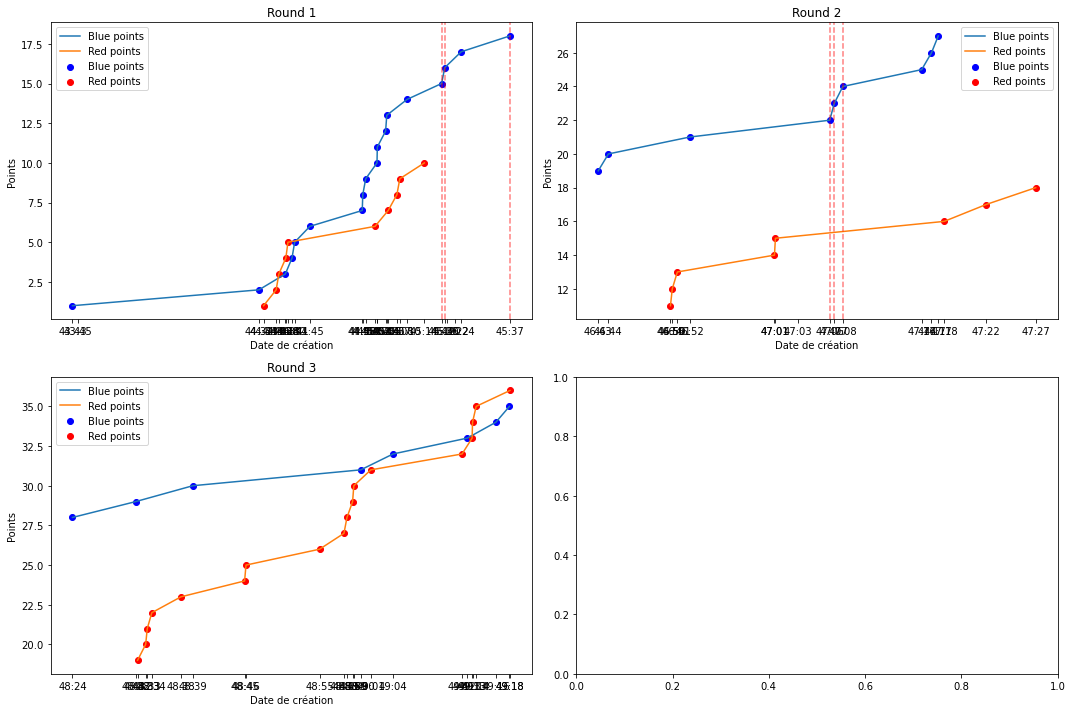

In [20]:
data['timestamp'] = data['date_create_app'].apply(lambda x: x.timestamp())

# Sélection des colonnes à utiliser pour le clustering
features = data[['timestamp']]
score_ids = data['score_id']

# Normalisation des caractéristiques
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Application de DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(normalized_features)

# Récupération des labels de cluster
labels = dbscan.labels_

# Récupération des indices des lignes pour chaque cluster
clusters = {}
for label in set(labels):
    if label != -1:  # Exclure la catégorie des outliers
        cluster_indices = [i for i, l in enumerate(labels) if l == label]
        lower_bound_index = min(cluster_indices)
        upper_bound_index = max(cluster_indices)
        lower_bound_score_id = score_ids.iloc[lower_bound_index]
        upper_bound_score_id = score_ids.iloc[upper_bound_index]
        clusters[label] = {'lower_bound_score_id': lower_bound_score_id,
                           'upper_bound_score_id': upper_bound_score_id}

# Affichage des bornes de chaque cluster
for label, bounds in clusters.items():
    print("Round", label+1)
    print("Score ID de la borne inférieure :", bounds['lower_bound_score_id'])
    print("Score ID de la borne supérieure :", bounds['upper_bound_score_id'])
    print()

# Filtrage des données pour les clusters sélectionnés
data_clusters = {}
for label, bounds in clusters.items():
    lower_bound_score_id = bounds['lower_bound_score_id']
    upper_bound_score_id = bounds['upper_bound_score_id']
    cluster_data = data[(data['score_id'] >= lower_bound_score_id) & (data['score_id'] <= upper_bound_score_id)]
    data_clusters[label] = cluster_data

# Paramètres pour la taille des sous-graphiques
num_clusters = len(data_clusters)
num_cols = 2
num_rows = (num_clusters + 1) // num_cols

# Création des sous-graphiques
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Initialisation des valeurs cumulées pour chaque cluster
cumulative_blue_points_prev = 0
cumulative_red_points_prev = 0

# Parcours de chaque cluster et affichage dans un sous-graphique
for i, (label, data_cluster) in enumerate(data_clusters.items()):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]

    # Filtrage des données pour le cluster
    cluster_data = data_cluster[['date_create_app', 'blue_point', 'red_point']]

    data_red_points = cluster_data[cluster_data['red_point'] == 1][['date_create_app', 'red_point']]
    data_blue_points = cluster_data[cluster_data['blue_point'] == 1][['date_create_app', 'blue_point']]

    cumulative_blue_points = cumulative_blue_points_prev + data_blue_points['blue_point'].cumsum()
    cumulative_red_points = cumulative_red_points_prev + data_red_points['red_point'].cumsum()

    cumulative_blue_points_prev = cumulative_blue_points.iloc[-1]
    cumulative_red_points_prev = cumulative_red_points.iloc[-1]

    # Affichage des données du cluster
    ax.plot(data_blue_points['date_create_app'], cumulative_blue_points, label='Blue points')
    ax.plot(data_red_points['date_create_app'], cumulative_red_points, label='Red points')

    # Affichage des points de coordonnées
    ax.scatter(data_blue_points['date_create_app'], cumulative_blue_points, c='blue', label='Blue points')
    ax.scatter(data_red_points['date_create_app'], cumulative_red_points, c='red', label='Red points')

    red_penalty_dates = data_cluster[data_cluster['red_penalty'] == 1]['date_create_app']
    for date in red_penalty_dates:
        ax.axvline(x=date, color='red', linestyle='--', alpha=0.5)

    blue_penalty_dates = data_cluster[data_cluster['blue_penalty'] == 1]['date_create_app']
    for date in blue_penalty_dates:
        ax.axvline(x=date, color='blue', linestyle='--', alpha=0.5)

    ax.set_xlabel('Date de création')
    ax.set_ylabel('Points')
    ax.set_title(f'Round {label+1}')
    ax.legend()

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

    ax.set_xticks(cluster_data['date_create_app'])
    ax.set_xticklabels(cluster_data['date_create_app'].dt.strftime('%M:%S'))

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage du graphe
plt.show()

In [21]:
# Parcours des rounds pour détecter les phases d'échanges avec DBSCAN
for round_label, round_data in data_clusters.items():

    # Sélection des colonnes à utiliser pour le clustering
    features = round_data[['timestamp']]

    # Normalisation des caractéristiques
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    # Application de DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan.fit(normalized_features)

    # Récupération des labels de cluster
    labels = dbscan.labels_

    # Récupération des indices des lignes pour chaque cluster
    clusters = {}
    for label in set(labels):
        if label != -1:  # Exclure la catégorie des outliers
            cluster_indices = [i for i, l in enumerate(labels) if l == label]
            lower_bound_index = min(cluster_indices)
            upper_bound_index = max(cluster_indices)
            lower_bound_score_id = round_data.iloc[lower_bound_index]['score_id']
            upper_bound_score_id = round_data.iloc[upper_bound_index]['score_id']
            clusters[label] = {'lower_bound_score_id': lower_bound_score_id,
                               'upper_bound_score_id': upper_bound_score_id}

    # Affichage des bornes de chaque cluster
    for label, bounds in clusters.items():
        print("Round", round_label + 1)
        print("Score ID de la borne inférieure :", bounds['lower_bound_score_id'])
        print("Score ID de la borne supérieure :", bounds['upper_bound_score_id'])
        print()

    # Filtrage des données pour les clusters sélectionnés
    data_clusters_round = {}
    for label, bounds in clusters.items():
        lower_bound_score_id = bounds['lower_bound_score_id']
        upper_bound_score_id = bounds['upper_bound_score_id']
        cluster_data = round_data[(round_data['score_id'] >= lower_bound_score_id) & (round_data['score_id'] <= upper_bound_score_id)]
        data_clusters_round[label] = cluster_data
        
  

Round 1
Score ID de la borne inférieure : 401
Score ID de la borne supérieure : 412

Round 1
Score ID de la borne inférieure : 413
Score ID de la borne supérieure : 430

Round 2
Score ID de la borne inférieure : 438
Score ID de la borne supérieure : 442

Round 2
Score ID de la borne inférieure : 443
Score ID de la borne supérieure : 448

Round 2
Score ID de la borne inférieure : 449
Score ID de la borne supérieure : 454

Round 3
Score ID de la borne inférieure : 455
Score ID de la borne supérieure : 464

Round 3
Score ID de la borne inférieure : 465
Score ID de la borne supérieure : 472

Round 3
Score ID de la borne inférieure : 476
Score ID de la borne supérieure : 483



### DTW

In [22]:
match_id_count = data[data['match_id'] == 21096].shape[0]
print("Nombre de lignes avec match_id 21096:", match_id_count)


Nombre de lignes avec match_id 21096: 75


In [23]:
print(data['date_create_app'].dtype)

datetime64[ns, UTC]


In [24]:
print(data['date_create_app'].isnull().sum())

0


In [25]:
# Fonction pour calculer la distance DTW entre deux séquences de dates
def dtw_distance(sequence1, sequence2):
    sequence1 = np.array(sequence1).reshape(-1, 1)
    sequence2 = np.array(sequence2).reshape(-1, 1)
    distance, _ = fastdtw(sequence1, sequence2, dist=euclidean)
    return distance

Round 1
Phase 1
Moyenne de closest_distance : 1329.3
Écart-type de closest_distance : 1299.6495296809828

   score_id date_create_app  closest_distance  match_id
0       401        11:44:32               100     21096
1       402        11:44:33              1199     21096
2       403        11:44:36              3261     21096
3       404        11:44:37               693     21096
4       405        11:44:38              1684     21096
5       406        11:44:38               125     21096
6       407        11:44:39               548     21096
7       408        11:44:40              1050     21096
8       410        11:44:41               685     21096
9       412        11:44:45              3948     21096



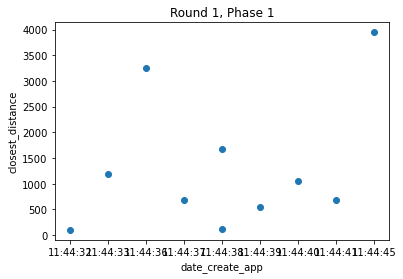

Phase 2
Moyenne de closest_distance : 1428.9444444444443
Écart-type de closest_distance : 1371.2948570483738

    score_id date_create_app  closest_distance  match_id
0        413        11:44:58               100     21096
1        414        11:44:58               139     21096
2        415        11:44:59               757     21096
3        416        11:45:02              2419     21096
4        417        11:45:02               507     21096
5        418        11:45:02                76     21096
6        419        11:45:04              2150     21096
7        420        11:45:05               300     21096
8        421        11:45:05               368     21096
9        422        11:45:07              2255     21096
10       423        11:45:08               753     21096
11       424        11:45:10              1891     21096
12       425        11:45:14              4475     21096
13       426        11:45:19              4453     21096
14       427        11:45:20       

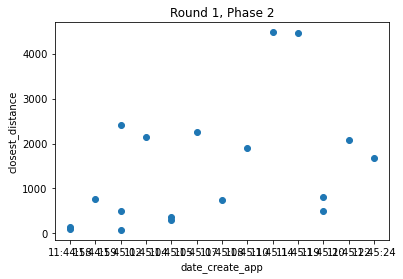

--------------------------------------------------------------------------------------
Round 2
Phase 1
Moyenne de closest_distance : 1667.4
Écart-type de closest_distance : 2629.2679209239977

   score_id date_create_app  closest_distance  match_id
0       438        11:46:44               100     21096
1       439        11:46:50              6302     21096
2       440        11:46:50               182     21096
3       441        11:46:51               517     21096
4       442        11:46:52              1236     21096



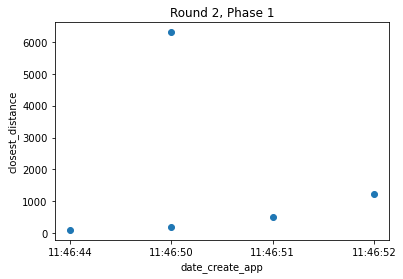

Phase 2
Moyenne de closest_distance : 1174.0
Écart-type de closest_distance : 1297.8070734897387

   score_id date_create_app  closest_distance  match_id
0       443        11:47:01               100     21096
1       444        11:47:01                96     21096
2       445        11:47:03              2253     21096
3       446        11:47:06              3259     21096
4       447        11:47:07               465     21096
5       448        11:47:08               871     21096



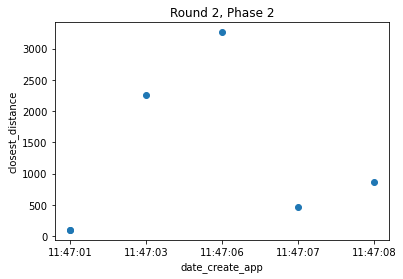

Phase 3
Moyenne de closest_distance : 1946.3333333333333
Écart-type de closest_distance : 2126.308789114758

   score_id date_create_app  closest_distance  match_id
0       449        11:47:16               100     21096
1       450        11:47:17               994     21096
2       451        11:47:17               689     21096
3       452        11:47:18               601     21096
4       453        11:47:22              4252     21096
5       454        11:47:27              5042     21096



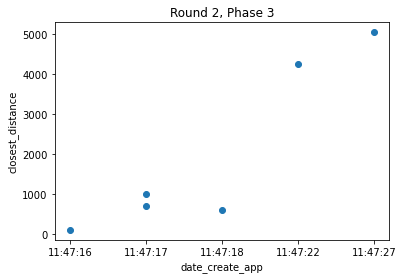

--------------------------------------------------------------------------------------
Round 3
Phase 1
Moyenne de closest_distance : 2144.1
Écart-type de closest_distance : 2818.640351895455

   score_id date_create_app  closest_distance  match_id
0       455        11:48:24               100     21096
1       456        11:48:32              7782     21096
2       457        11:48:32               224     21096
3       458        11:48:33               996     21096
4       459        11:48:33               198     21096
5       460        11:48:34               560     21096
6       461        11:48:38              3580     21096
7       462        11:48:39              1462     21096
8       463        11:48:45              6366     21096
9       464        11:48:46               173     21096



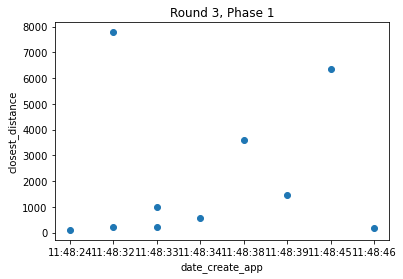

Phase 2
Moyenne de closest_distance : 1142.0
Écart-type de closest_distance : 1129.5240464144938

   score_id date_create_app  closest_distance  match_id
0       465        11:48:55               100     21096
1       466        11:48:58              2999     21096
2       467        11:48:58               372     21096
3       468        11:48:59               690     21096
4       469        11:48:59               151     21096
5       470        11:49:00               854     21096
6       471        11:49:01              1239     21096
7       472        11:49:04              2731     21096



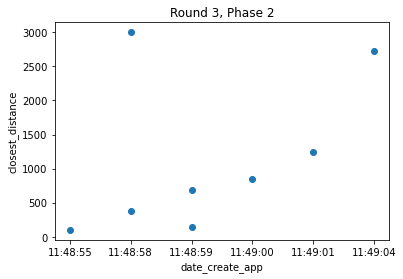

Phase 3
Moyenne de closest_distance : 748.5
Écart-type de closest_distance : 859.4948682635799

   score_id date_create_app  closest_distance  match_id
0       476        11:49:12               100     21096
1       477        11:49:13               642     21096
2       478        11:49:13               595     21096
3       479        11:49:13                53     21096
4       480        11:49:14               445     21096
5       481        11:49:16              2425     21096
6       482        11:49:18              1671     21096
7       483        11:49:18                57     21096



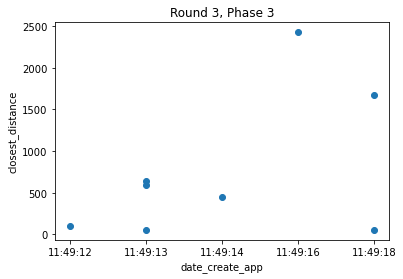

--------------------------------------------------------------------------------------


In [26]:
# Parcours des rounds pour appliquer DBSCAN à chaque round
for round_label, round_data in data_clusters.items():
    print("Round", round_label + 1)
    
    # Sélection des colonnes à utiliser pour le clustering
    features = round_data[['timestamp']]

    # Normalisation des caractéristiques
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    # Application de DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan.fit(normalized_features)

    # Récupération des labels de round
    round_labels = dbscan.labels_

    # Récupération des indices des lignes pour chaque round
    round_clusters = {}
    for label in set(round_labels):
        if label != -1:  # Exclure la catégorie des outliers
            cluster_indices = [i for i, l in enumerate(round_labels) if l == label]
            lower_bound_index = min(cluster_indices)
            upper_bound_index = max(cluster_indices)
            lower_bound_score_id = score_ids.iloc[lower_bound_index]
            upper_bound_score_id = score_ids.iloc[upper_bound_index]
            round_clusters[label] = {'lower_bound_score_id': lower_bound_score_id,
                                      'upper_bound_score_id': upper_bound_score_id}

    # Parcours des clusters du round actuel
    for cluster_label, cluster_bounds in round_clusters.items():
        cluster_data = round_data[(round_labels == cluster_label) & (round_labels != -1)]
        
        print('Phase', cluster_label+1)
        # Tri du cluster_data par score_id
        sorted_cluster_data = cluster_data.sort_values('score_id')

        # Création d'une colonne pour stocker la distance la plus proche
        sorted_cluster_data['closest_distance'] = 100

        # Conversion de la colonne date_create_app en valeurs de temps en millisecondes
        sorted_cluster_data['timestamp_ms'] = sorted_cluster_data['date_create_app'].view('int64') // 10**6

        # Parcours des lignes pour calculer la distance la plus proche
        for i in range(1, len(sorted_cluster_data)):
            current_row = sorted_cluster_data.iloc[i]
            previous_row = sorted_cluster_data.iloc[i-1]
            current_sequence = current_row['timestamp_ms']
            previous_sequence = previous_row['timestamp_ms']
            distance = dtw_distance(current_sequence, previous_sequence)
            sorted_cluster_data.at[current_row.name, 'closest_distance'] = distance

        # Calcul des statistiques des distances
        mean_distance = sorted_cluster_data['closest_distance'].mean()
        std_distance = sorted_cluster_data['closest_distance'].std()

        # Affichage des statistiques
        print("Moyenne de closest_distance :", mean_distance)
        print("Écart-type de closest_distance :", std_distance)
        print()

        # Affichage des colonnes spécifiées pour les données du cluster
        cols_to_display = ['score_id', 'date_create_app', 'closest_distance', 'match_id']

        # Formater la colonne date_create_app au format heures, minutes, secondes et millisecondes
        sorted_cluster_data['date_create_app'] = sorted_cluster_data['date_create_app'].apply(lambda x: x.strftime('%H:%M:%S'))

        # Réinitialiser l'index
        sorted_cluster_data = sorted_cluster_data.reset_index(drop=True)

        print(sorted_cluster_data[cols_to_display])
        print()
        # Affichage du graphe des nuages de points
        plt.scatter(sorted_cluster_data['date_create_app'], sorted_cluster_data['closest_distance'])
        plt.xlabel('date_create_app')
        plt.ylabel('closest_distance')
        plt.title(f"Round {round_label + 1}, Phase {cluster_label + 1}")
        plt.show()
    print ('--------------------------------------------------------------------------------------')


In [27]:
# Parcours des rounds pour appliquer DBSCAN à chaque round
all_echanges = []  # Liste pour stocker tous les échanges de chaque round

for round_label, round_data in data_clusters.items():
    print("Round", round_label + 1)
    
    # Sélection des colonnes à utiliser pour le clustering
    features = round_data[['timestamp']]

    # Normalisation des caractéristiques
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    # Application de DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan.fit(normalized_features)

    # Récupération des labels de round
    round_labels = dbscan.labels_

    # Récupération des indices des lignes pour chaque round
    round_clusters = {}
    for label in set(round_labels):
        if label != -1:  # Exclure la catégorie des outliers
            cluster_indices = [i for i, l in enumerate(round_labels) if l == label]
            lower_bound_index = min(cluster_indices)
            upper_bound_index = max(cluster_indices)
            lower_bound_score_id = score_ids.iloc[lower_bound_index]
            upper_bound_score_id = score_ids.iloc[upper_bound_index]
            round_clusters[label] = {'lower_bound_score_id': lower_bound_score_id,
                                      'upper_bound_score_id': upper_bound_score_id}

    # Parcours des clusters du round actuel
    for cluster_label, cluster_bounds in round_clusters.items():
        cluster_data = round_data[(round_labels == cluster_label) & (round_labels != -1)]

        print('Phase', cluster_label+1)
        # Tri du cluster_data par score_id
        sorted_cluster_data = cluster_data.sort_values('score_id')

        # Création d'une colonne pour stocker la distance la plus proche
        sorted_cluster_data['closest_distance'] = 100

        # Conversion de la colonne date_create_app en valeurs de temps en millisecondes
        sorted_cluster_data['timestamp_ms'] = sorted_cluster_data['date_create_app'].view('int64') // 10**6

        # Parcours des lignes pour calculer la distance la plus proche
        for i in range(1, len(sorted_cluster_data)):
            current_row = sorted_cluster_data.iloc[i]
            previous_row = sorted_cluster_data.iloc[i-1]
            current_sequence = current_row['timestamp_ms']
            previous_sequence = previous_row['timestamp_ms']
            distance = dtw_distance(current_sequence, previous_sequence)
            sorted_cluster_data.at[current_row.name, 'closest_distance'] = distance

        # Calcul des statistiques des distances
        filtered_cluster_data_no_inf = sorted_cluster_data[sorted_cluster_data['closest_distance'] != np.inf]
        mean_distance = filtered_cluster_data_no_inf['closest_distance'].mean()
        std_distance = filtered_cluster_data_no_inf['closest_distance'].std()

        # Affichage des statistiques
        print("Moyenne de closest_distance :", mean_distance)
        print("Écart-type de closest_distance :", std_distance)
        print()

        # Séparation des lignes en echange dès qu'une ligne a un closest_distance supérieur à l'écart-type
        echanges = []
        current_echange = []
        for i, row in sorted_cluster_data.iterrows():
            if row['closest_distance'] > std_distance:
                if current_echange:
                    echanges.append(current_echange)
                current_echange = [row]
            else:
                current_echange.append(row)
        if current_echange:
            echanges.append(current_echange)

        # Vérification du nombre de "judge_id" différents dans chaque échange et création de la colonne "outlier"
        for echange in echanges:
            judge_ids = set(row['judge_id'] for row in echange)
            if len(judge_ids) >= 2:
                for row in echange:
                    row['outlier'] = False
            else:
                for row in echange:
                    row['outlier'] = True

        # Filtrage des échanges pour une seule ligne par judge_id
        filtered_echanges = []
        for echange in echanges:
            unique_judge_ids = set(row['judge_id'] for row in echange)
            if len(unique_judge_ids) == len(echange):
                filtered_echanges.append(echange)
            else:
                grouped_rows = []
                for judge_id in unique_judge_ids:
                    judge_rows = [row for row in echange if row['judge_id'] == judge_id]
                    grouped_rows.append(min(judge_rows, key=lambda x: x['closest_distance']))
                filtered_echanges.append(grouped_rows)

        # Affichage des colonnes spécifiées pour chaque échange
        cols_to_display = ['score_id', 'date_create_app', 'closest_distance', 'match_id', 'judge_id', 'red_point', 'blue_point', 'red_penalty', 'blue_penalty', 'round','phase','echange','outlier']
        for i, echange in enumerate(filtered_echanges):
            print("Echange", i + 1)
            df_echange = pd.DataFrame(echange, columns=cols_to_display)

            # Formater la colonne date_create_app au format heures, minutes, secondes et millisecondes
            df_echange['date_create_app'] = df_echange['date_create_app'].apply(lambda x: x.strftime('%H:%M:%S'))

            # Ajouter les nouvelles colonnes
            df_echange['round'] = round_label + 1
            df_echange['phase'] = cluster_label + 1
            df_echange['echange'] = i + 1

            print(df_echange)
            print()

            # Ajouter les données de l'échange à la liste globale des échanges
            all_echanges.append(df_echange)


Round 1
Phase 1
Moyenne de closest_distance : 1329.3
Écart-type de closest_distance : 1299.6495296809828

Echange 1
     score_id date_create_app  closest_distance  match_id  judge_id  \
400       401        11:44:32               100     21096    114813   
401       402        11:44:33              1199     21096    114826   

     red_point  blue_point  red_penalty  blue_penalty  round  phase  echange  \
400          0           1            0             0      1      1        1   
401          1           0            0             0      1      1        1   

     outlier  
400    False  
401    False  

Echange 2
     score_id date_create_app  closest_distance  match_id  judge_id  \
402       403        11:44:36              3261     21096    114813   
403       404        11:44:37               693     21096    114819   

     red_point  blue_point  red_penalty  blue_penalty  round  phase  echange  \
402          1           0            0             0      1      1        2   

     score_id date_create_app  closest_distance  match_id  judge_id  \
450       451        11:47:17               689     21096    114826   
448       449        11:47:16               100     21096    114819   
449       450        11:47:17               994     21096    114813   

     red_point  blue_point  red_penalty  blue_penalty  round  phase  echange  \
450          0           1            0             0      2      3        1   
448          0           1            0             0      2      3        1   
449          0           1            0             0      2      3        1   

     outlier  
450    False  
448    False  
449    False  

Echange 2
     score_id date_create_app  closest_distance  match_id  judge_id  \
452       453        11:47:22              4252     21096    114826   

     red_point  blue_point  red_penalty  blue_penalty  round  phase  echange  \
452          1           0            0             0      2      3        2   

     outlier  
452 

### détecter les outliers manquants et les ajouter

- ajouter les outliers à l'export pour les mettre directement à TRUE
- corriger les outliers
    - s'il un outlier est un red_penalty ou blue_penalty, il n'est pas outlier
    - s'il y a une ligne négative, ce n'est pas un outlier mais une correction
    - s'il y a un échange avec 3 judge_id mais que sur les 3, un a un choix erroné, c'est une erreur
- tester sur tous les dataset

### Export

In [28]:
# Créer le DataFrame global
df_all_echanges = pd.concat(all_echanges)

# Exporter le DataFrame dans un fichier CSV
output_file = 'all_echanges.csv'
df_all_echanges.to_csv(output_file, index=False)

print("Les échanges ont été exportés avec succès dans le fichier", output_file)

Les échanges ont été exportés avec succès dans le fichier all_echanges.csv


### Lien entre vainqueur et arbitre

- trouver ID du club de arbitre et celui du combattant et voir combien de point attribué par juge lors du combat lorsquil y a son cadet 

In [29]:
data2 = pd.read_csv('LCBA_scores.csv')

cols_to_display = ['score_id', 'red_point','red_penalty', 'blue_point','blue_penalty', 'date_create_app', 'judge_id', 'match_id','PalmaresRedClubID','PalmaresBlueClubID', 'judge_club_id']
data2[cols_to_display]

,score_id,red_point,red_penalty,blue_point,blue_penalty,date_create_app,judge_id,match_id,PalmaresRedClubID,PalmaresBlueClubID,judge_club_id
0,1,0,0,0,0,NaN,114816,21089,157,67,118
1,2,0,0,0,0,NaN,114822,21089,157,67,101
2,3,0,0,0,0,NaN,114824,21089,157,67,153
3,4,0,0,0,0,NaN,114826,21093,153,67,158
4,5,0,0,0,0,NaN,114813,21093,153,67,22
...,...,...,...,...,...,...,...,...,...,...,...
38778,38952,1,0,0,0,2023-04-15 14:18:52.2+00,115226,22514,95,47,120
38779,38953,1,0,0,0,2023-04-15 14:18:51.485+00,114927,22514,95,47,118
38780,38954,1,0,0,0,2023-04-15 14:18:56.33+00,114927,22514,95,47,118
38781,38955,1,0,0,0,2023-04-15 14:18:56.889+00,114926,22514,95,47,118


In [30]:
matching_match_ids = set()

for index, row in data2.iterrows():
    judge_club_id = row['judge_club_id']
    if row['PalmaresRedClubID'] == judge_club_id or row['PalmaresBlueClubID'] == judge_club_id:
        match_id = row['match_id']
        matching_match_ids.add(match_id)

if not matching_match_ids:
    print("Aucun match_id correspondant trouvé.")
else:
    for match_id in matching_match_ids:
        print(match_id)


22026
22027
22031
22044
22046
22048
22051
22052
22054
22056
22059
22060
22062
22067
22068
22069
22070
22072
22073
22088
22089
22090
22091
22092
22093
22094
22095
21601
21608
21609
21623
21624
21632
21633
21122
21634
21124
21125
21127
21128
21130
21131
21133
21649
21651
22163
22164
21654
21143
21658
21147
21659
21660
22170
21663
21664
22171
21666
21667
22175
22176
22183
21672
22185
21674
21677
22206
22208
22209
22211
22214
22215
22217
22218
22219
22223
22226
22228
22230
22232
22233
22235
22236
22238
22239
22241
22242
22243
22250
22254
22255
22256
22258
22259
22261
22262
22263
22264
22265
22266
22267
22268
22269
22270
22271
22272
21761
22273
21763
21767
21768
21769
22282
21771
21260
21261
21262
21263
21773
21265
21269
21270
22293
21272
21273
22294
22295
22297
22298
21278
21791
22300
22301
21282
22302
21284
22303
22305
22306
21288
21801
22308
21291
22309
22311
21806
22313
21296
21809
22315
22317
22319
22320
21814
22322
21816
22327
22328
21819
22329
22330
22335
22342
22346
21325
21326
2183

### Juges ayant des jugements biaisés

- comparer le nombre de points attribué à chaque combat avec les autres juges

### Score pour le niveau des arbitres 

- attribuer un score s'il possède beaucoup d'outliers

### Corrélation

In [31]:
import pandas as pd

# Charger les données depuis le fichier CSV
data = pd.read_csv('LCBA_scores.csv')

# Calculer la corrélation entre toutes les colonnes du dataset
correlation_matrix = data.corr()

# Afficher la matrice de corrélation
print(correlation_matrix)


                          score_id  red_penalty  red_point  blue_penalty  \
score_id                  1.000000     0.022430   0.000054      0.019372   
red_penalty               0.022430     1.000000  -0.223083     -0.077166   
red_point                 0.000054    -0.223083   1.000000      0.502399   
blue_penalty              0.019372    -0.077166   0.502399      1.000000   
blue_point                0.008534     0.469524  -0.666991     -0.230716   
judge_id                 -0.065969    -0.003283   0.003939     -0.001488   
match_id                  0.994292     0.022673  -0.000833      0.021322   
judge_club_id            -0.051153    -0.017286  -0.000719     -0.015275   
match_id.1                0.994292     0.022673  -0.000833      0.021322   
PalmaresRedCountRanking   0.264866     0.021419   0.004178      0.011416   
PalmaresBlueCountRanking  0.275131     0.024739  -0.000575      0.025961   
PalmaresRound             0.142281     0.031346   0.072436      0.055814   
PalmaresFigh

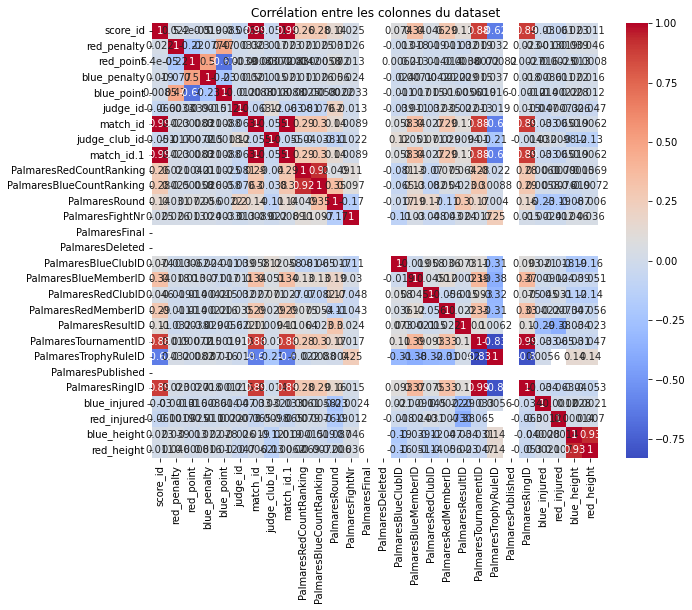

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Créer un heatmap de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Corrélation entre les colonnes du dataset')
plt.show()


### L'autocorrélation


Autocorrélation pour le juge 114816: -0.26712328767123317


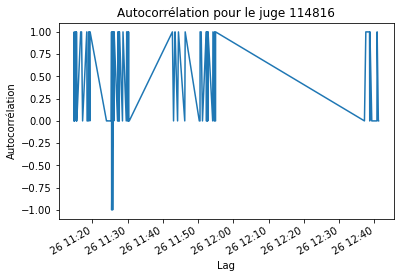

Autocorrélation pour le juge 114822: -0.2248164926201482


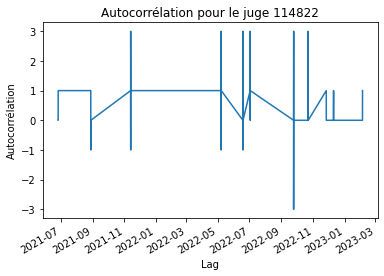

Autocorrélation pour le juge 114824: -0.09130080848959735


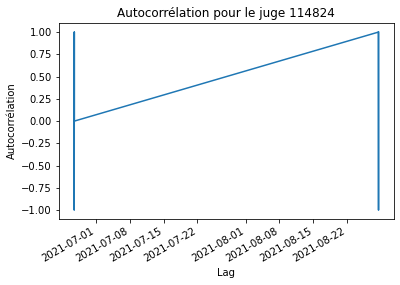

Autocorrélation pour le juge 114826: -0.07424476474244446


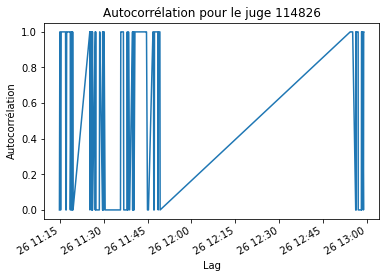

Autocorrélation pour le juge 114813: -0.03424737816274912


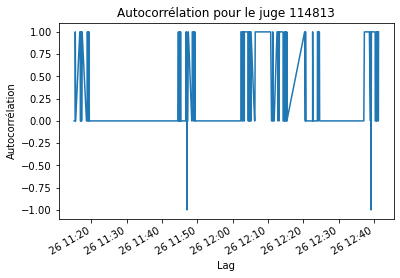

Autocorrélation pour le juge 114823: 0.2024316109422493


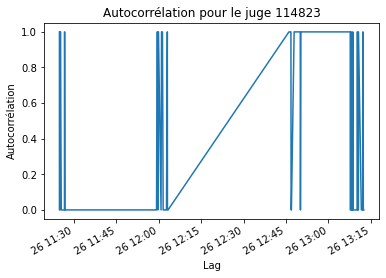

Autocorrélation pour le juge 113583: -0.0579240560397926


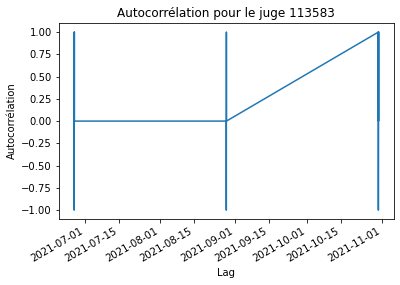

Autocorrélation pour le juge 114808: -0.08150960250111648


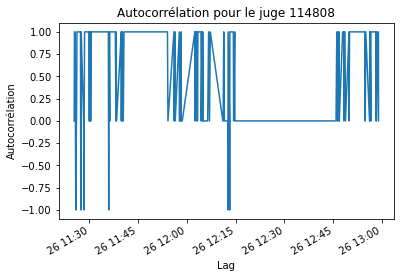

Autocorrélation pour le juge 114820: 0.035189783083649236


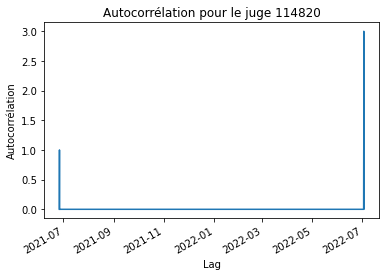

Autocorrélation pour le juge 114815: -0.19242047974589666


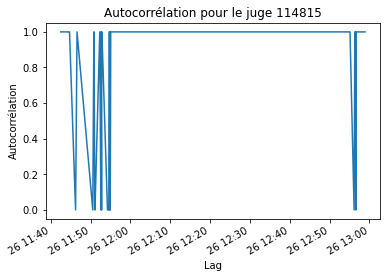

Autocorrélation pour le juge 114819: 0.22604790419161655


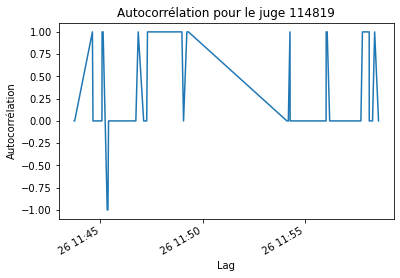

Autocorrélation pour le juge 114810: -0.10682630491274316


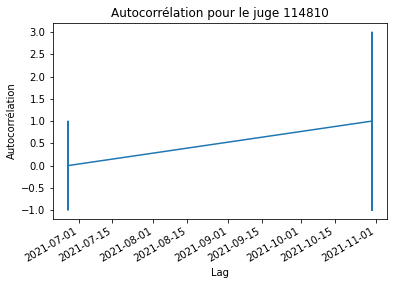

Autocorrélation pour le juge 107723: -0.188311688311688


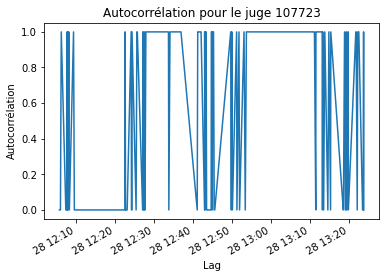

Autocorrélation pour le juge 113268: -0.14208189442525904


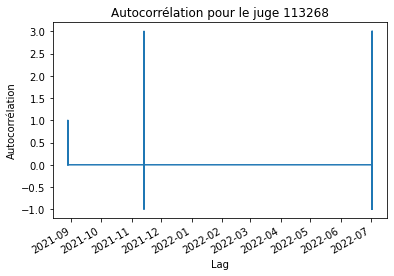

Autocorrélation pour le juge 113341: -0.01653971224302019


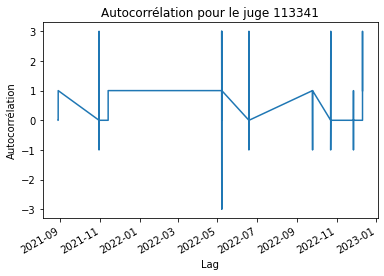

Autocorrélation pour le juge 104593: -0.015587997476392487


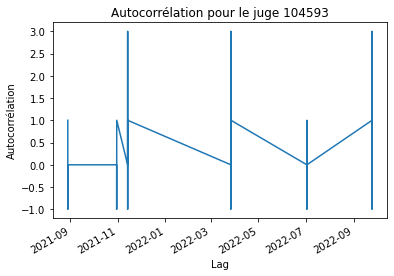

Autocorrélation pour le juge 113165: -0.0022254036610922724


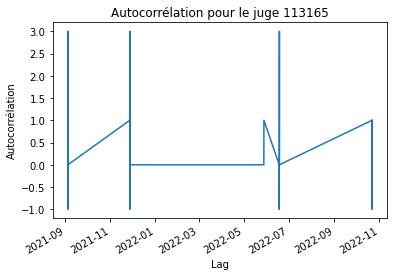

Autocorrélation pour le juge 114863: -0.06805240235557423


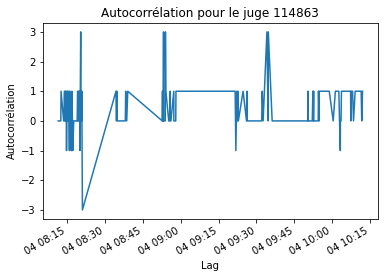

Autocorrélation pour le juge 100124: -0.10052858408541426


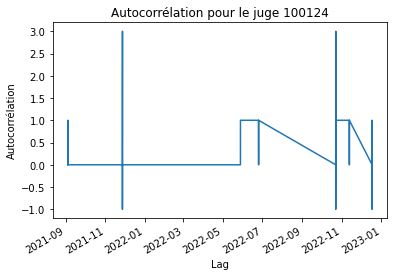

Autocorrélation pour le juge 110224: -0.0034773969200196267


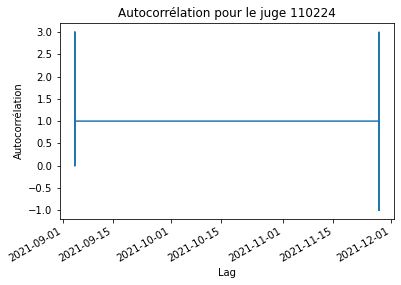

Autocorrélation pour le juge 109018: -0.12040539657057636


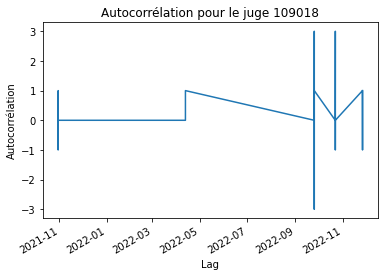

Autocorrélation pour le juge 114928: -0.13423845810133403


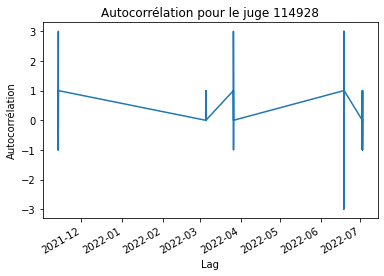

Autocorrélation pour le juge 114926: -0.08127735760271622


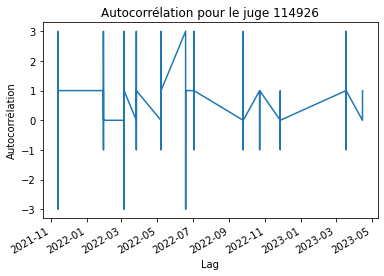

Autocorrélation pour le juge 114927: -0.13552960575203504


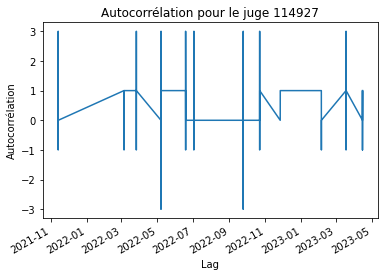

Autocorrélation pour le juge 114981: -0.022399884759435135


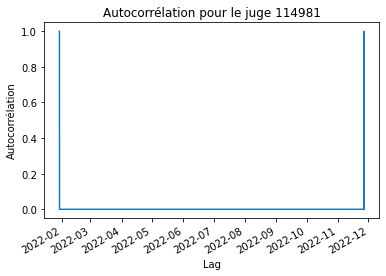

Autocorrélation pour le juge 114971: -0.12618256738006173


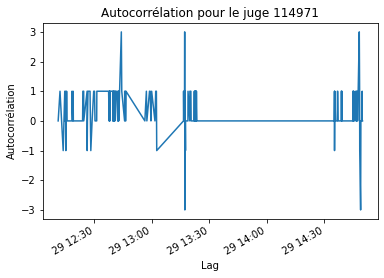

Autocorrélation pour le juge 114965: -0.21219157310378692


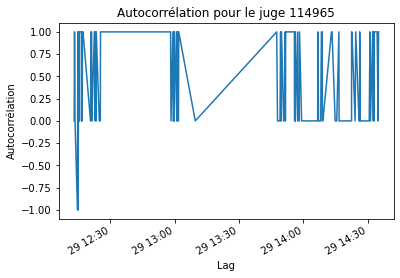

Autocorrélation pour le juge 114972: -0.1497438987646886


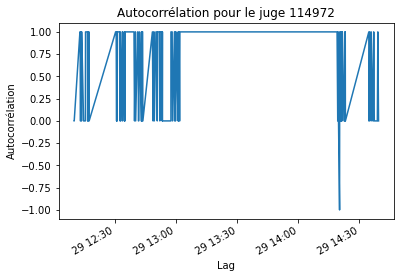

Autocorrélation pour le juge 114988: -0.14769647696476976


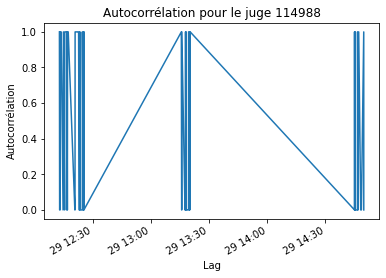

Autocorrélation pour le juge 102054: 0.02788233879972706


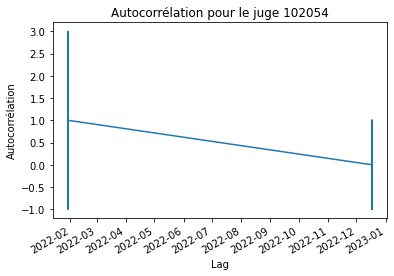

Autocorrélation pour le juge 114979: -0.03026315789473677


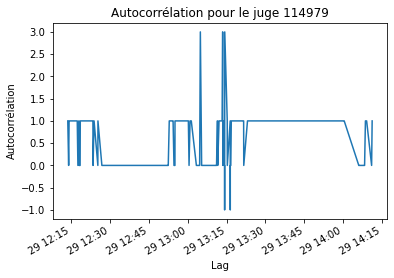

Autocorrélation pour le juge 114970: 0.1358739769304691


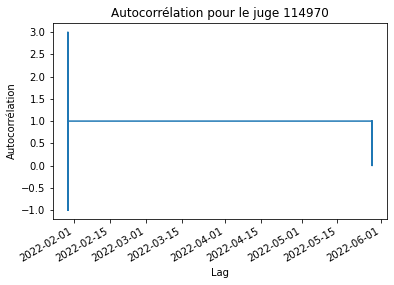

Autocorrélation pour le juge 114980: -0.32824397594488736


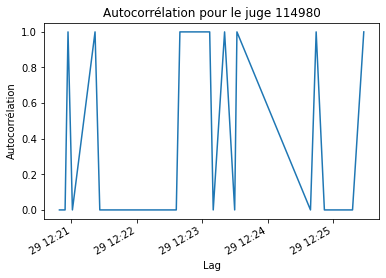

Autocorrélation pour le juge 114973: -0.2444716685009521


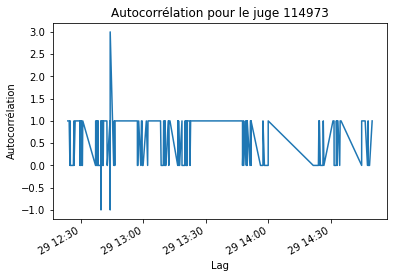

Autocorrélation pour le juge 114975: -0.11277491810949924


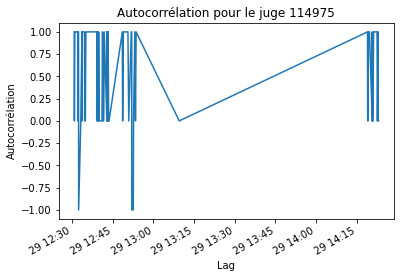

Autocorrélation pour le juge 114976: -0.00667160859896221


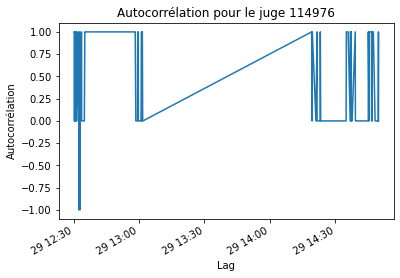

Autocorrélation pour le juge 114969: -0.06726139294926904


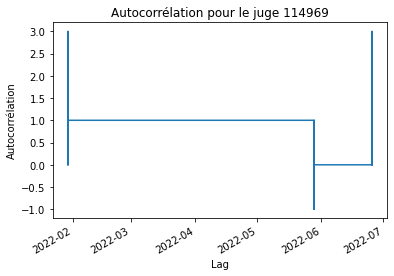

Autocorrélation pour le juge 114974: -0.13957650486539677


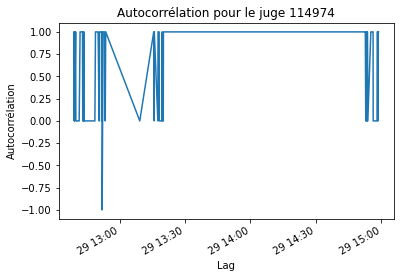

Autocorrélation pour le juge 114889: -0.11713107322293152


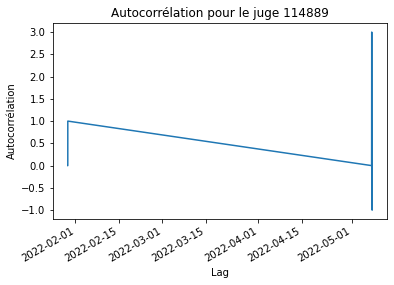

Autocorrélation pour le juge 114929: -0.11602181385852028


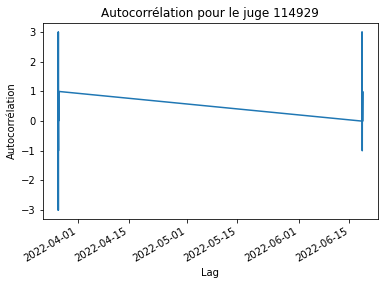

Autocorrélation pour le juge 113368: -0.03585373317298431


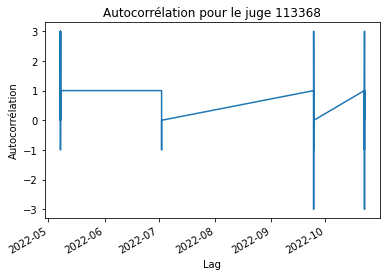

Autocorrélation pour le juge 104652: -0.06669308134501864


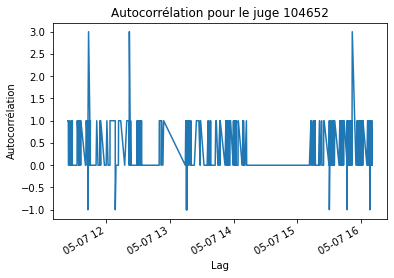

Autocorrélation pour le juge 103092: -0.04533673981699998


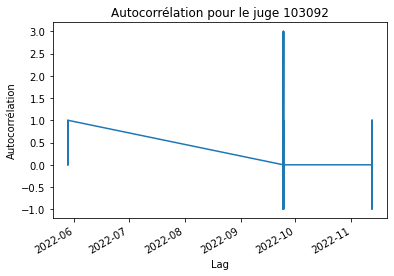

Autocorrélation pour le juge 114872: -0.16081814043574036


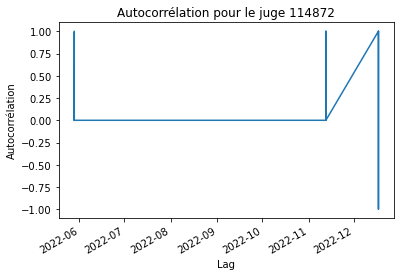

Autocorrélation pour le juge 114794: -0.17573825811325058


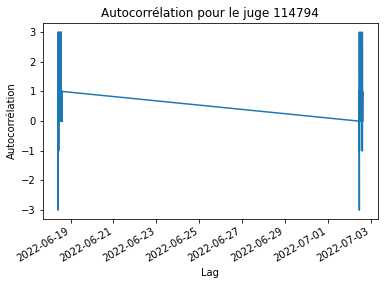

Autocorrélation pour le juge 105535: -0.11285653374026587


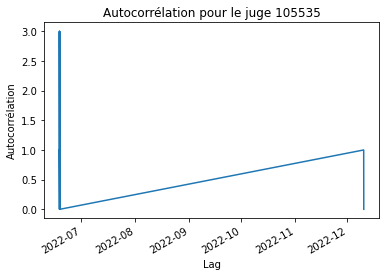

Autocorrélation pour le juge 115083: -0.1644817495764672


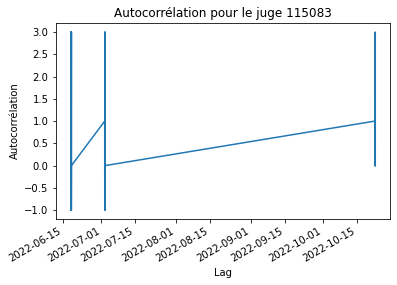

Autocorrélation pour le juge 114967: -0.20478601012425154


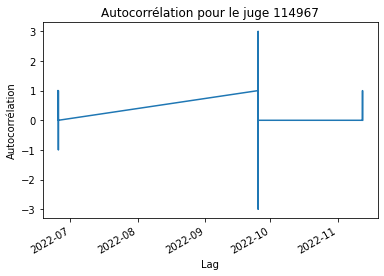

Autocorrélation pour le juge 114968: -0.175982431615668


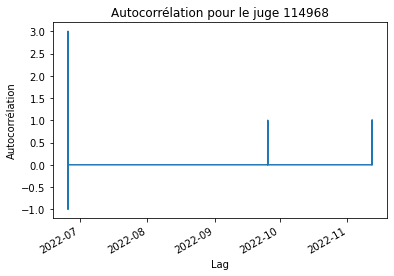

Autocorrélation pour le juge 115082: -0.110032362459547


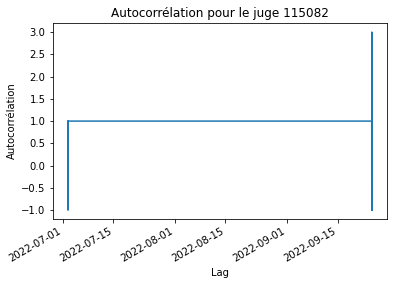

Autocorrélation pour le juge 111958: -0.1450476021907972


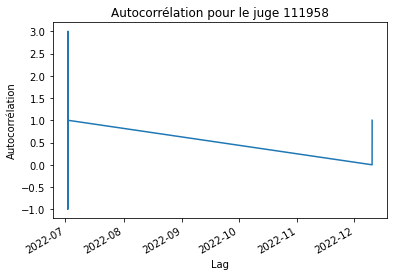

Autocorrélation pour le juge 115081: -0.14239095146958092


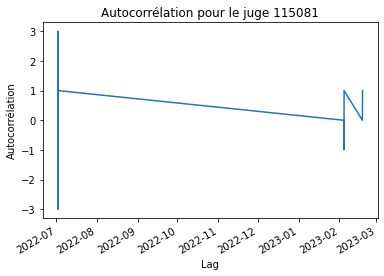

Autocorrélation pour le juge 104830: -0.019153672683005912


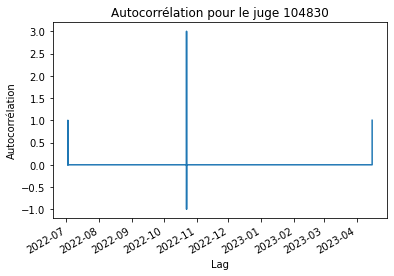

Autocorrélation pour le juge 115158: -0.06827944968029971


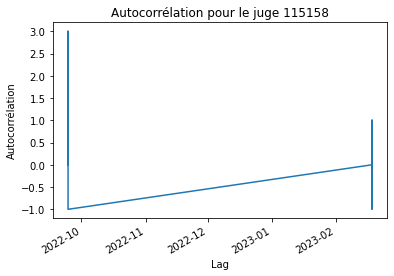

Autocorrélation pour le juge 115149: -0.21471690450257483


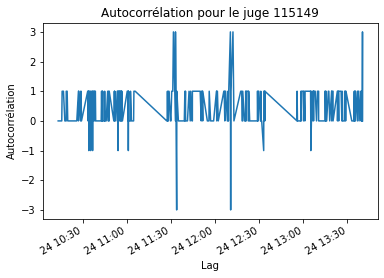

Autocorrélation pour le juge 115163: -0.04340181380714411


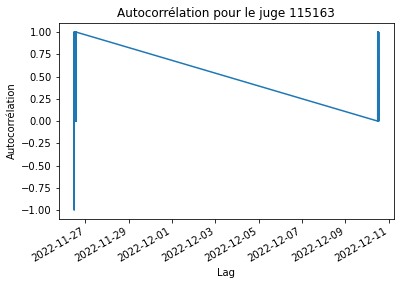

Autocorrélation pour le juge 105358: -0.1424206806061571


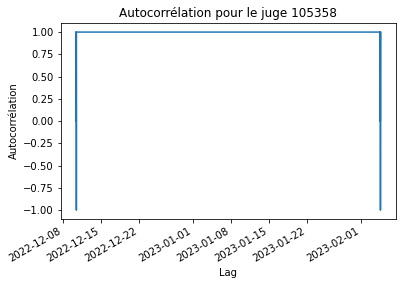

Autocorrélation pour le juge 111556: -0.16120244246124926


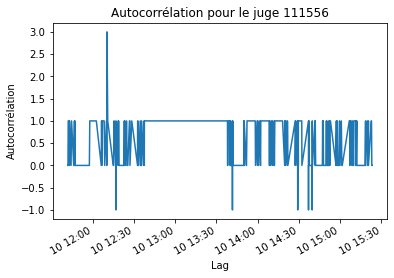

Autocorrélation pour le juge 104691: -0.11672585115107884


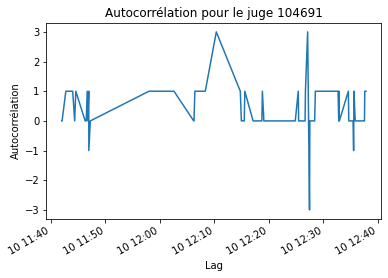

Autocorrélation pour le juge 115164: -0.08274857672448052


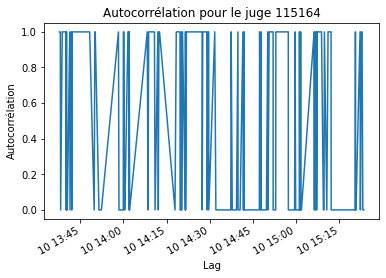

Autocorrélation pour le juge 115093: -0.010575793184488877


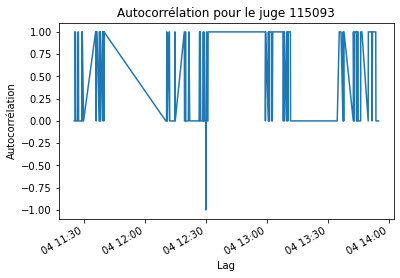

Autocorrélation pour le juge 115226: 0.034952005445131135


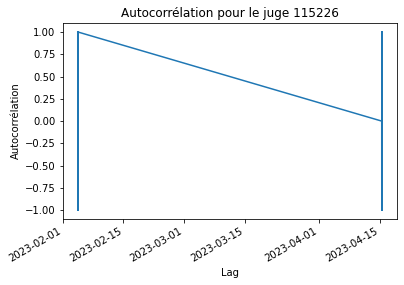

Autocorrélation pour le juge 115261: -0.09837183508402346


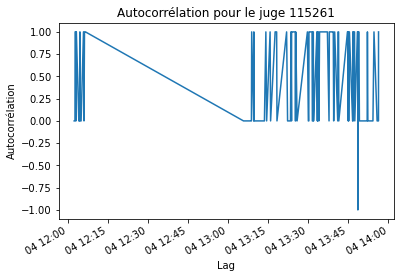

Autocorrélation pour le juge 115276: -0.00730020361281851


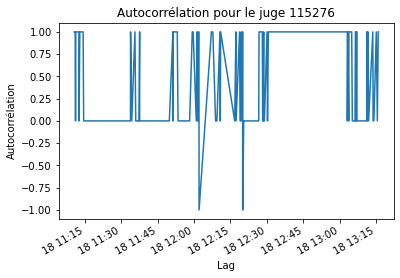

Autocorrélation pour le juge 115266: -0.21944035346097257


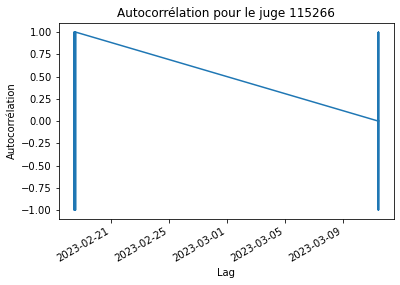

Autocorrélation pour le juge 115277: -0.21691395498269017


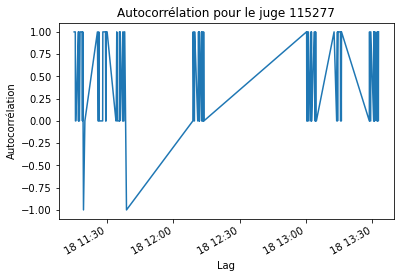

Autocorrélation pour le juge 115278: -0.20811400608807082


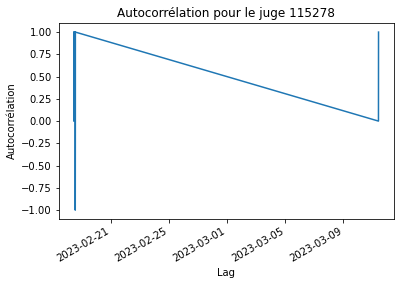

Autocorrélation pour le juge 100787: -0.11980939414567782


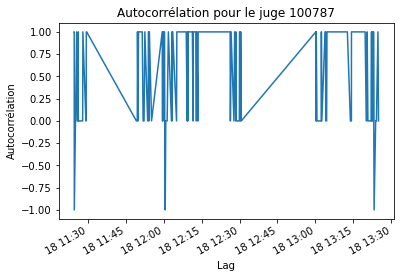

Autocorrélation pour le juge 115284: 0.004732927653820202


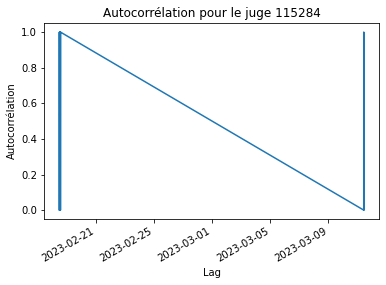

Autocorrélation pour le juge 115285: -0.3768216516308112


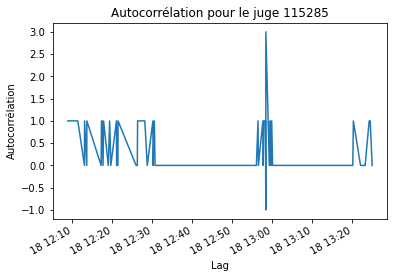

Autocorrélation pour le juge 115085: -0.08491095247116644


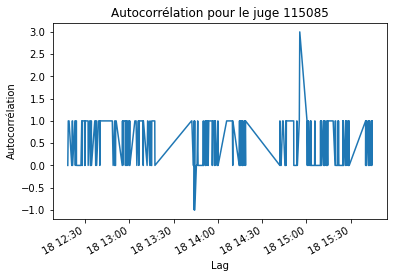

Autocorrélation pour le juge 115086: -0.17815072637350085


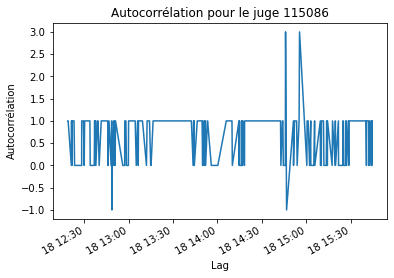

Autocorrélation pour le juge 115087: -0.1480788366578059


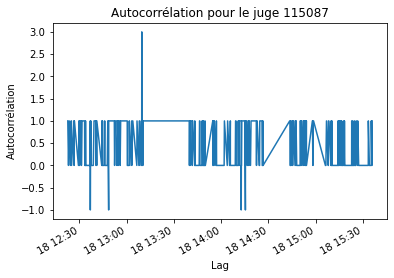

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger les données depuis le fichier CSV
data = pd.read_csv('LCBA_scores.csv')

# Convertir la colonne 'date_create_app' en format de date et l'utiliser comme index
data['date_create_app'] = pd.to_datetime(data['date_create_app'])
data.set_index('date_create_app', inplace=True)

# Sélectionner les colonnes pertinentes pour l'analyse
columns = ['red_point', 'blue_point', 'judge_id']
data = data[columns]

# Calculer l'autocorrélation pour chaque juge
judges = data['judge_id'].unique()
for judge in judges:
    judge_data = data[data['judge_id'] == judge]
    autocorr = judge_data['red_point'].autocorr()
    print(f"Autocorrélation pour le juge {judge}: {autocorr}")

    # Tracer le graphique de l'autocorrélation
    judge_data['red_point'].plot(title=f"Autocorrélation pour le juge {judge}")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrélation")
    plt.show()


Autocorrélation pour le juge 114816: -0.27349425230236596


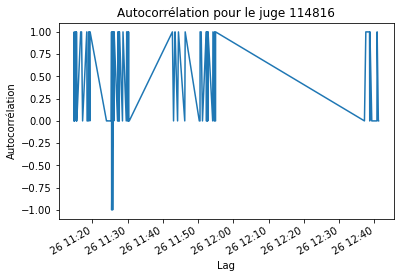

Autocorrélation pour le juge 114822: -0.22222125631414094


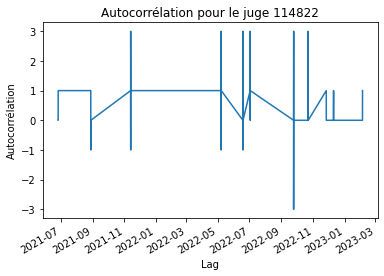

Autocorrélation pour le juge 114824: -0.10893715801691237


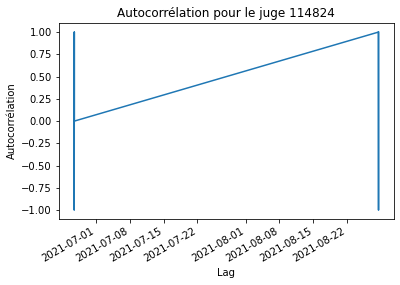

Autocorrélation pour le juge 114826: -0.11184755592377778


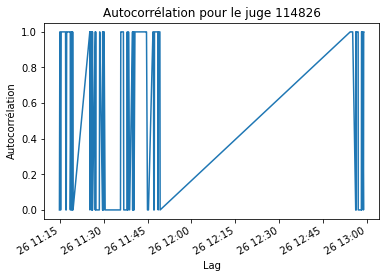

Autocorrélation pour le juge 114813: -0.06833791208791222


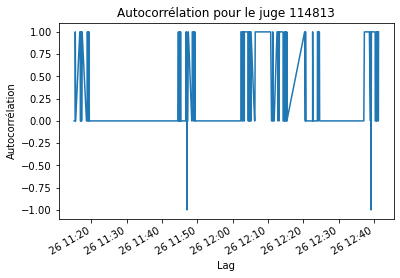

Autocorrélation pour le juge 114823: 0.24126631845827679


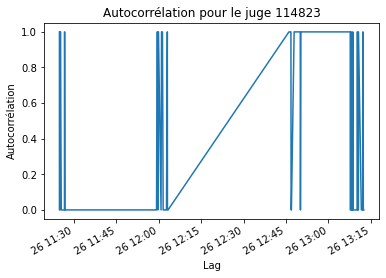

Autocorrélation pour le juge 113583: -0.059252581544009635


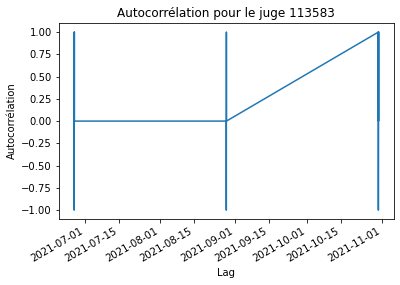

Autocorrélation pour le juge 114808: -0.06137252036481345


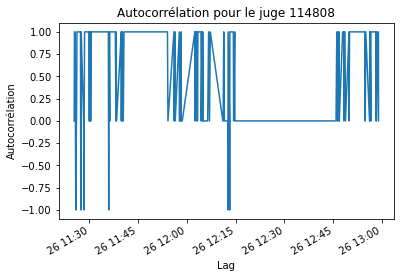

Autocorrélation pour le juge 114820: -0.05434782608695641


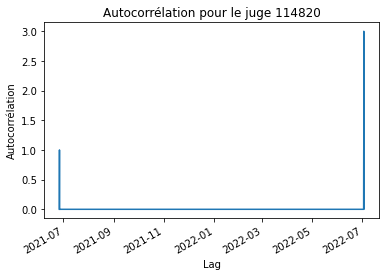

Autocorrélation pour le juge 114815: -0.12637362637362629


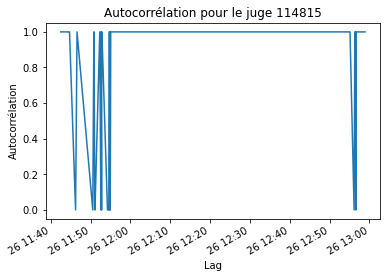

Autocorrélation pour le juge 114819: 0.16279089332490965


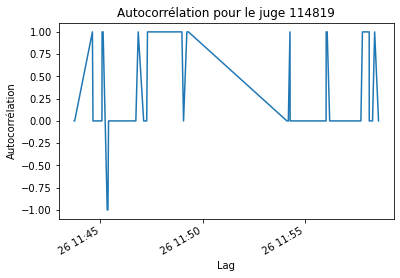

Autocorrélation pour le juge 114810: 0.030097911879308707


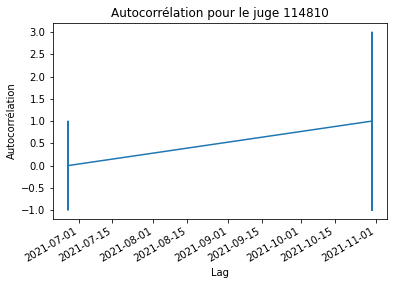

Autocorrélation pour le juge 107723: -0.2050782522827173


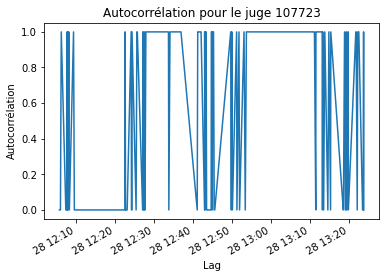

Autocorrélation pour le juge 113268: -0.15510439806495357


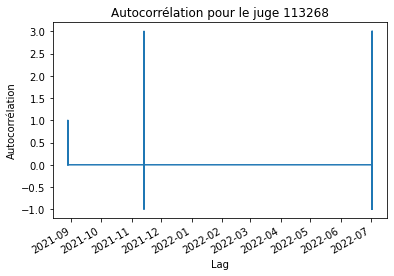

Autocorrélation pour le juge 113341: -0.02797880951330763


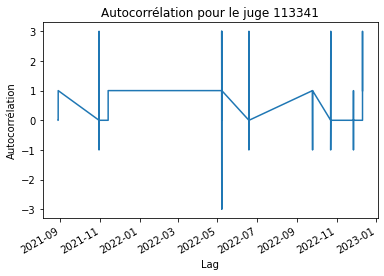

Autocorrélation pour le juge 104593: -0.01802801225716925


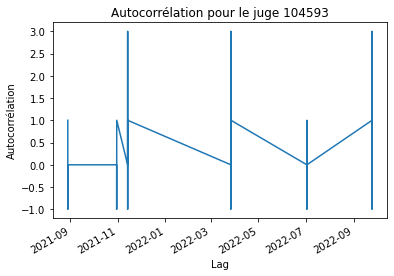

Autocorrélation pour le juge 113165: 0.03029794803827081


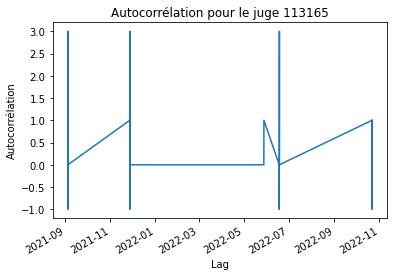

Autocorrélation pour le juge 114863: 0.160532879128901


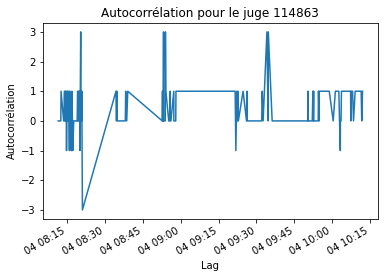

Autocorrélation pour le juge 100124: -0.07370678763666255


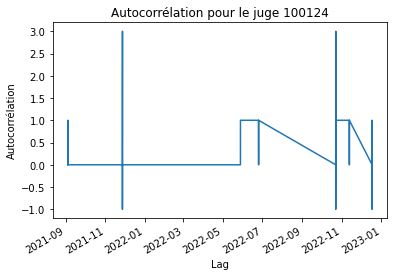

Autocorrélation pour le juge 110224: -0.12814191753819534


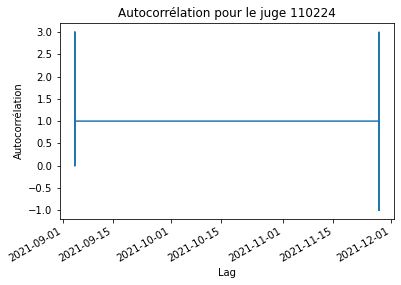

Autocorrélation pour le juge 109018: -0.04765235416908284


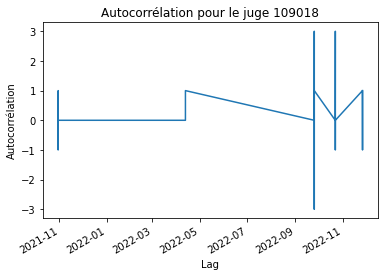

Autocorrélation pour le juge 114928: -0.1532315696089541


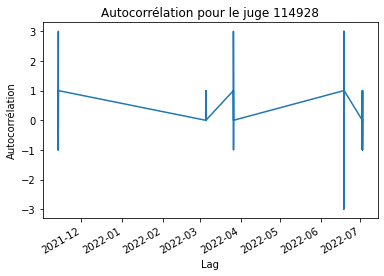

Autocorrélation pour le juge 114926: -0.058319052568077845


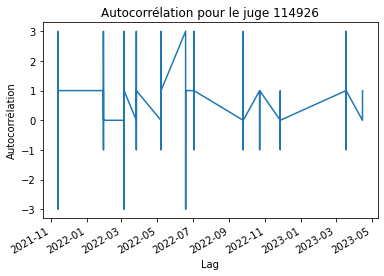

Autocorrélation pour le juge 114927: -0.11831629535975141


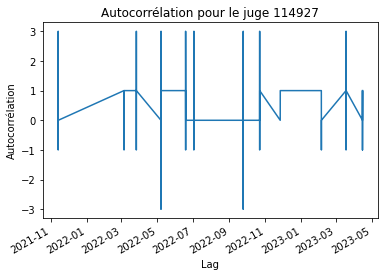

Autocorrélation pour le juge 114981: -0.10705311703585117


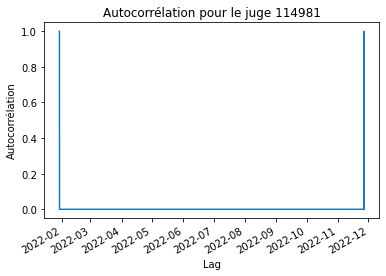

Autocorrélation pour le juge 114971: -0.026026905300199844


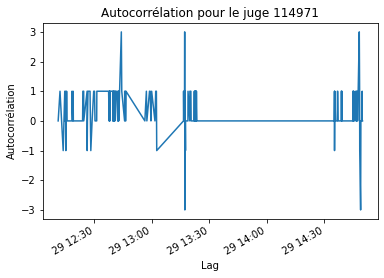

Autocorrélation pour le juge 114965: -0.31325656923531153


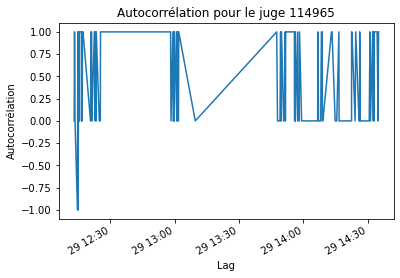

Autocorrélation pour le juge 114972: -0.18414001118238194


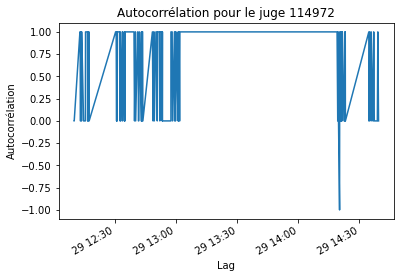

Autocorrélation pour le juge 114988: -0.11186251345579998


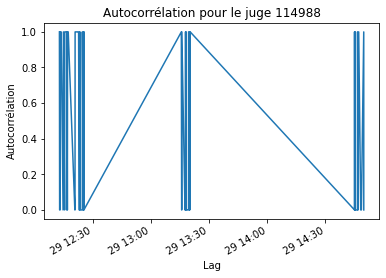

Autocorrélation pour le juge 102054: 0.051097040200264975


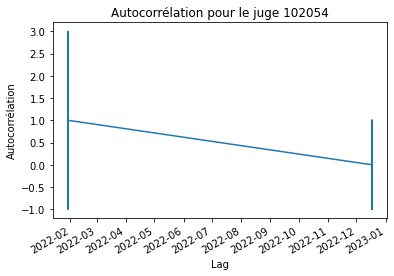

Autocorrélation pour le juge 114979: -0.13760896637608963


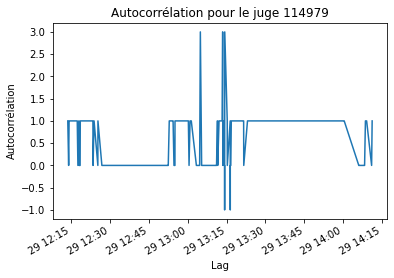

Autocorrélation pour le juge 114970: -0.05575006733099839


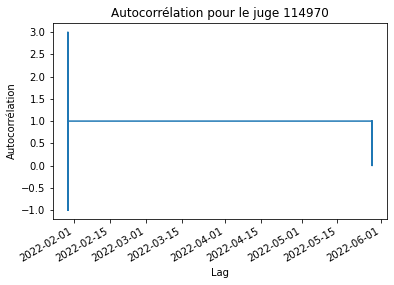

Autocorrélation pour le juge 114980: -0.4141414141414141


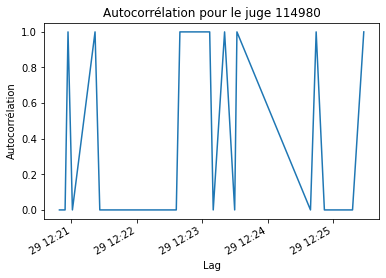

Autocorrélation pour le juge 114973: -0.11749347258485618


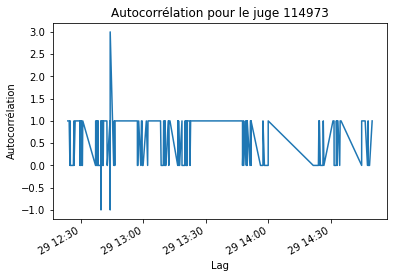

Autocorrélation pour le juge 114975: -0.1601933012888984


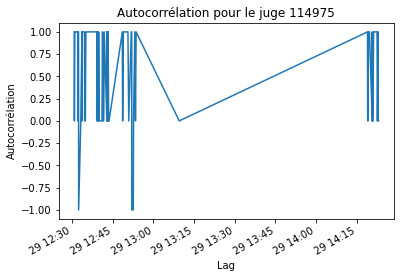

Autocorrélation pour le juge 114976: -0.015810296439946053


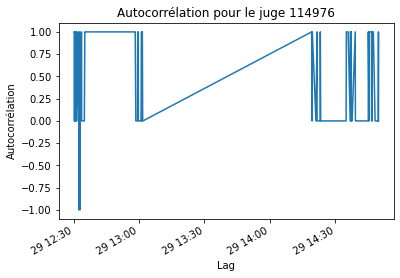

Autocorrélation pour le juge 114969: -0.09110728078570612


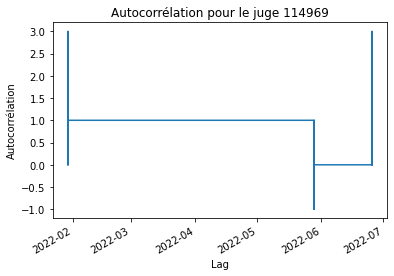

Autocorrélation pour le juge 114974: -0.11277173913043488


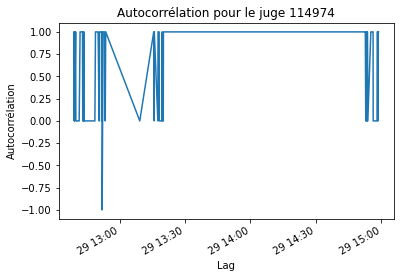

Autocorrélation pour le juge 114889: -0.1046294476115587


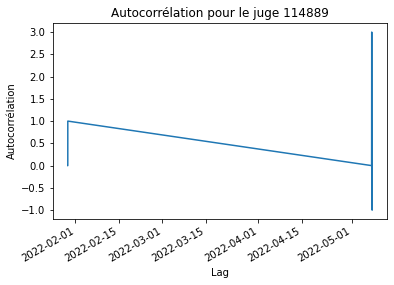

Autocorrélation pour le juge 114929: -0.034589126825195604


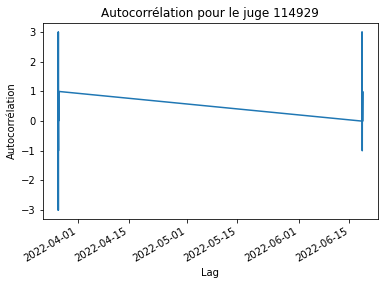

Autocorrélation pour le juge 113368: -0.10136214185063361


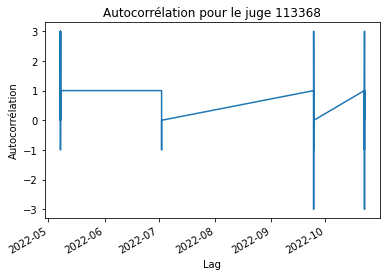

Autocorrélation pour le juge 104652: -0.13772623458425834


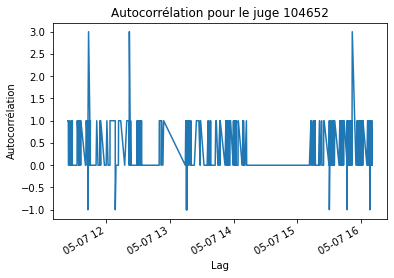

Autocorrélation pour le juge 103092: -0.10006044288147668


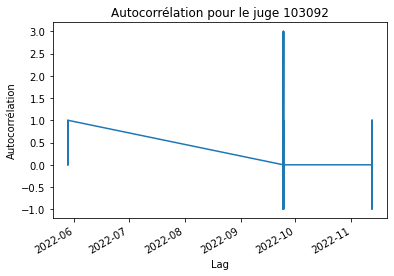

Autocorrélation pour le juge 114872: -0.0920319420851258


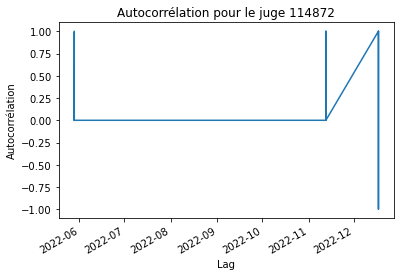

Autocorrélation pour le juge 114794: -0.04594769426924666


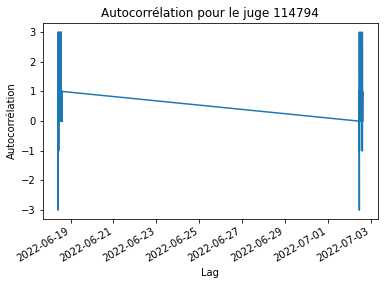

Autocorrélation pour le juge 105535: -0.15802815126234065


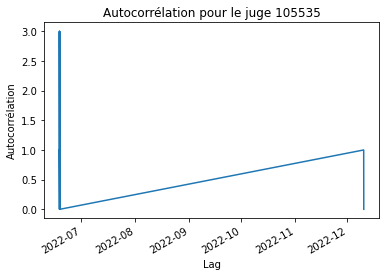

Autocorrélation pour le juge 115083: -0.20839377620295696


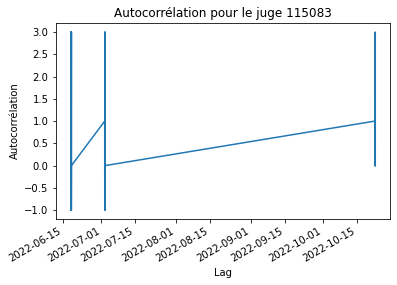

Autocorrélation pour le juge 114967: -0.07269437078392789


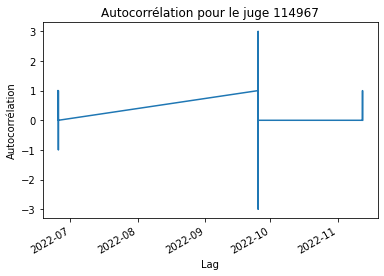

Autocorrélation pour le juge 114968: -0.12777152589798932


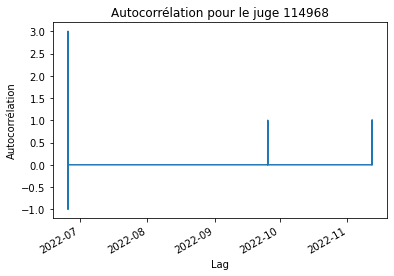

Autocorrélation pour le juge 115082: -0.10871856151344397


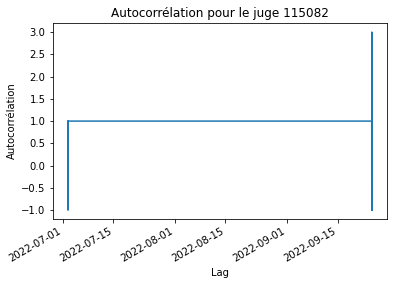

Autocorrélation pour le juge 111958: -0.11524770097893755


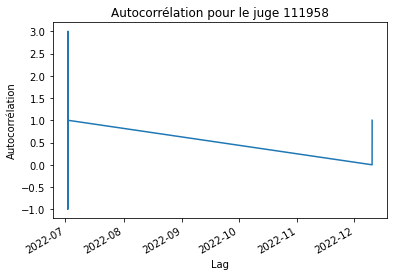

Autocorrélation pour le juge 115081: -0.16680882173754133


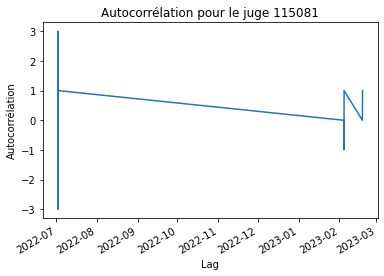

Autocorrélation pour le juge 104830: -0.026915615906886355


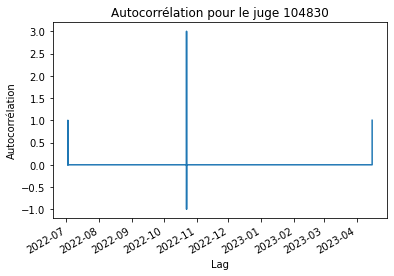

Autocorrélation pour le juge 115158: -0.02453723633232896


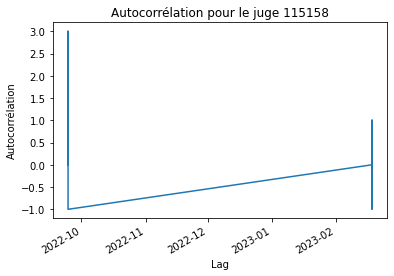

Autocorrélation pour le juge 115149: -0.1418070491498156


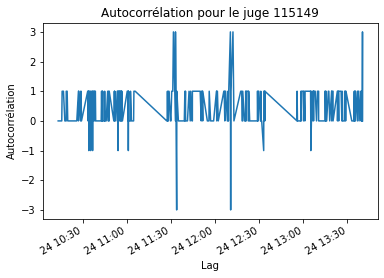

Autocorrélation pour le juge 115163: -0.08465999731928774


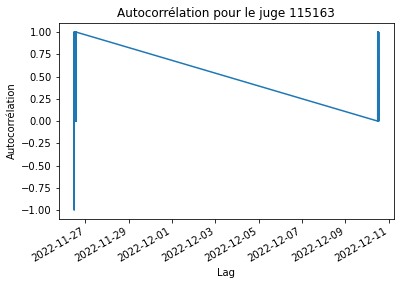

Autocorrélation pour le juge 105358: -0.12033011024204007


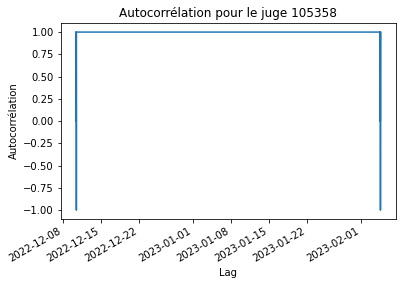

Autocorrélation pour le juge 111556: -0.21420111774271067


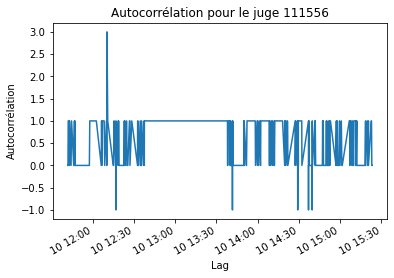

Autocorrélation pour le juge 104691: 0.10835913312693501


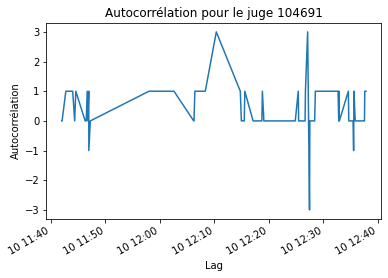

Autocorrélation pour le juge 115164: -0.07493525680256882


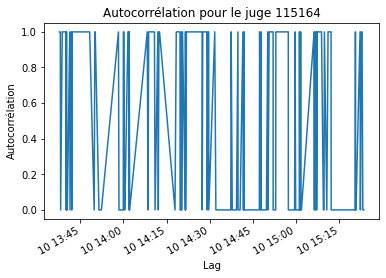

Autocorrélation pour le juge 115093: -0.11083173437377812


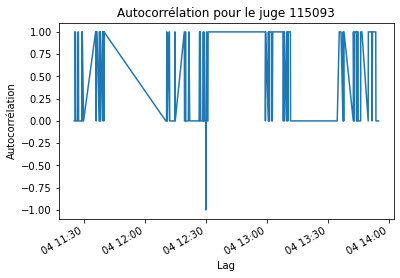

Autocorrélation pour le juge 115226: -0.0045089980447706604


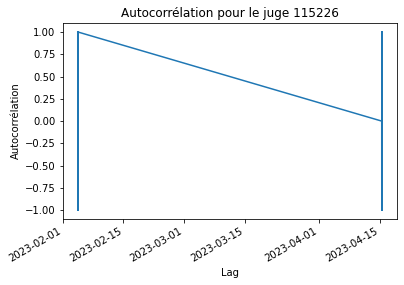

Autocorrélation pour le juge 115261: -0.10842834786496794


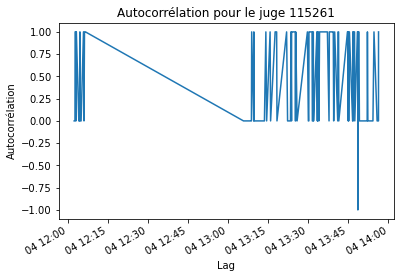

Autocorrélation pour le juge 115276: -0.12340425531914861


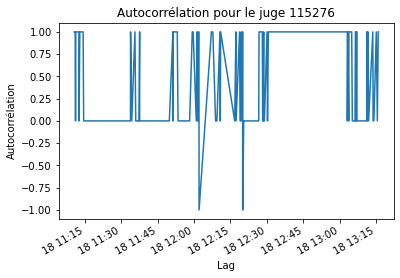

Autocorrélation pour le juge 115266: 0.031815839894838535


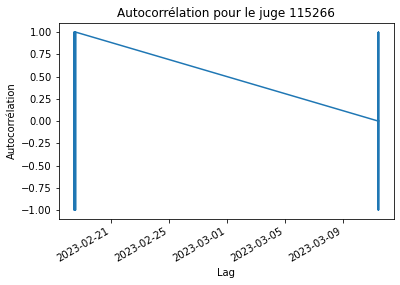

Autocorrélation pour le juge 115277: -0.2228721258572004


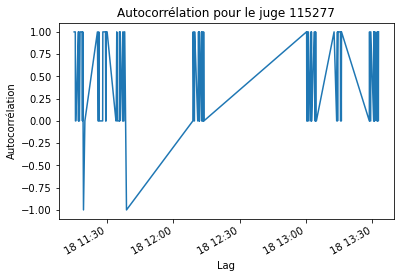

Autocorrélation pour le juge 115278: -0.1313755795981454


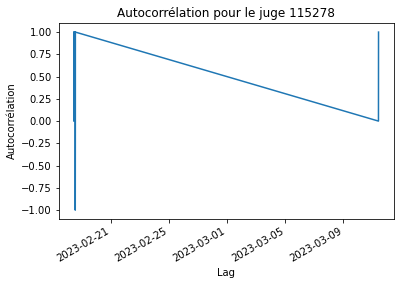

Autocorrélation pour le juge 100787: -0.05310211950613265


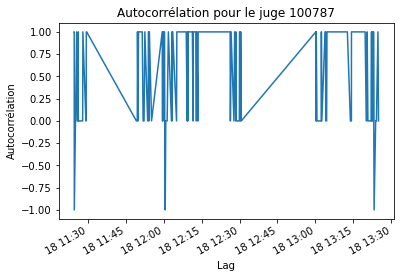

Autocorrélation pour le juge 115284: 0.18825015669596606


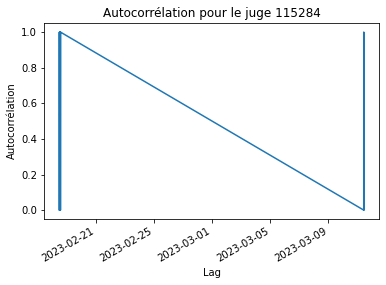

Autocorrélation pour le juge 115285: -0.25819888974716126


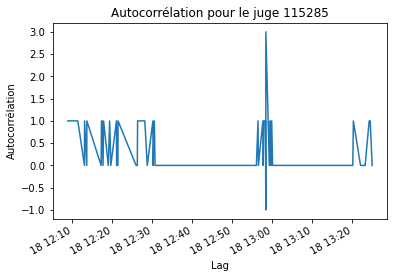

Autocorrélation pour le juge 115085: -0.09801503069244456


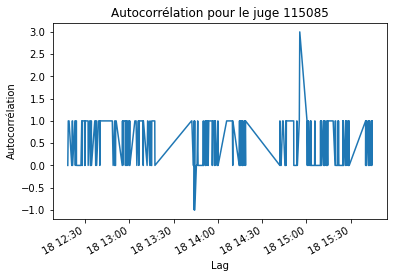

Autocorrélation pour le juge 115086: -0.13711790393013182


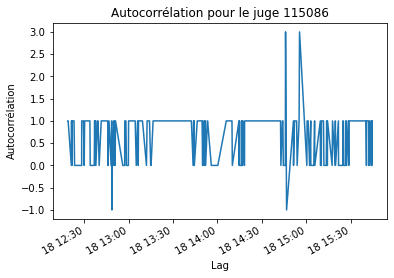

Autocorrélation pour le juge 115087: -0.11369536996971029


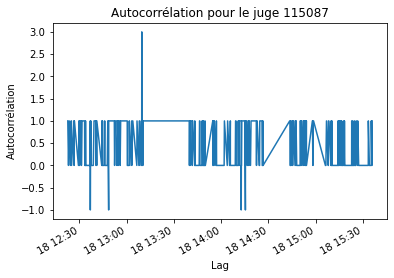

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger les données depuis le fichier CSV
data = pd.read_csv('LCBA_scores.csv')

# Convertir la colonne 'date_create_app' en format de date et l'utiliser comme index
data['date_create_app'] = pd.to_datetime(data['date_create_app'])
data.set_index('date_create_app', inplace=True)

# Sélectionner les colonnes pertinentes pour l'analyse
columns = ['red_point', 'blue_point', 'judge_id']
data = data[columns]

# Calculer l'autocorrélation pour chaque juge
judges = data['judge_id'].unique()
for judge in judges:
    judge_data = data[data['judge_id'] == judge]
    autocorr = judge_data['blue_point'].autocorr()
    print(f"Autocorrélation pour le juge {judge}: {autocorr}")

    # Tracer le graphique de l'autocorrélation
    judge_data['red_point'].plot(title=f"Autocorrélation pour le juge {judge}")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrélation")
    plt.show()


### ARIMA


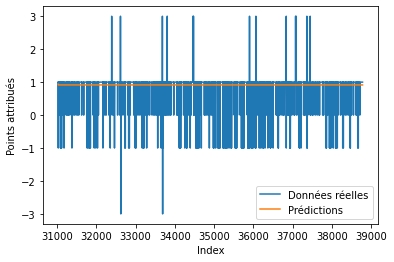

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Charger les données depuis le fichier CSV
data = pd.read_csv('LCBA_scores.csv')


# Créer une série temporelle des points attribués
points_series = data[['red_point', 'blue_point']].sum(axis=1)

# Diviser les données en ensembles d'entraînement et de test
train_size = int(len(points_series) * 0.8)
train_data, test_data = points_series[:train_size], points_series[train_size:]

# Créer le modèle ARIMA
model = ARIMA(train_data, order=(1, 0, 0))  # Ordre p=1, d=0, q=0 (à ajuster selon vos données)

# Ajuster le modèle aux données d'entraînement
model_fit = model.fit()

# Prévoir les points pour les données de test
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Afficher les prédictions par rapport aux données réelles
plt.plot(test_data.index, test_data.values, label='Données réelles')
plt.plot(test_data.index, predictions, label='Prédictions')
plt.xlabel('Index')
plt.ylabel('Points attribués')
plt.legend()
plt.show()


### VAR

In [36]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR

# Charger les données depuis le fichier CSV
data = pd.read_csv('LCBA_scores.csv')

# Sélectionner les colonnes pertinentes
columns = ['date_create_app', 'judge_id', 'red_point', 'blue_point']
data = data[columns]

# Convertir la colonne 'date_create_app' en datetime
data['date_create_app'] = pd.to_datetime(data['date_create_app'])

# Créer un DataFrame avec les données des juges
judge_data = pd.pivot_table(data, values=['red_point', 'blue_point'], index='date_create_app', columns='judge_id')

# Remplir les valeurs manquantes avec 0
judge_data = judge_data.fillna(0)

# Réorganiser les colonnes du DataFrame
judge_data = judge_data.reorder_levels([1, 0], axis=1)
judge_data = judge_data.sort_index(axis=1)

# Estimer le modèle VAR
model = VAR(judge_data)
results = model.fit()

# Afficher les résultats
results.summary()


C:\Users\Ray\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


TypeError: sequence item 0: expected str instance, int found